In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, auc, roc_curve, brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [2]:
def ece_score(y_test, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')
    bin_size = 1.0 / n_bins
    ece = 0.0
    for true, pred in zip(prob_true, prob_pred):
        ece += np.abs(true - pred) * bin_size
    return ece

# Модель для кредитных карт (звонки)

In [13]:
train_df = pd.read_csv('marketing_optimization_data/credit_card_call_train.csv')
test_df = pd.read_csv('marketing_optimization_data/credit_card_call_oot.csv')

In [129]:
test_df.tail()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,target
19995,2.302255,2.728247,0.865722,0.734934,4.493932,1.033784,-0.310140,-0.302902,-0.443703,-1.778741,...,-0.108024,-1.804365,-1.050717,2.235785,0.229605,0.299605,-2.431580,0.104849,0.690770,0
19996,-0.873454,1.062136,-0.597417,-0.286881,-3.062967,1.251512,1.187671,0.878910,0.609908,4.797885,...,-0.078935,1.646334,-3.184762,-0.273990,0.564567,-0.611445,-0.552841,7.516009,-3.174107,1
19997,1.261244,4.413201,1.703510,4.155988,-3.018253,-2.029029,-0.098222,0.675323,-0.114372,1.854732,...,8.634471,-0.997987,0.764638,-2.275093,-0.140334,1.115376,0.161935,3.520213,-6.487645,0
19998,0.321480,-7.805528,1.162574,3.353931,-1.888273,-0.259787,-1.317121,-1.471049,-0.941123,0.411780,...,3.526800,0.481263,-0.670567,1.292645,0.324343,0.910497,-0.158463,-11.376877,-3.017548,0
19999,0.599213,0.819747,-4.009429,-1.598829,-1.763672,5.844889,-0.697375,0.288702,1.055308,1.106483,...,-4.060293,-0.331683,0.735515,0.131148,-0.754999,-1.308966,-5.093874,-6.063577,1.516765,0


In [14]:
X_train, y_train = train_df.drop(['target'], axis=1), train_df['target']
X_test, y_test = test_df.drop(['target'], axis=1), test_df['target']

In [15]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
print(classification_report(y_test, y_pred := lr_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18506
           1       0.90      0.48      0.63      1494

    accuracy                           0.96     20000
   macro avg       0.93      0.74      0.80     20000
weighted avg       0.95      0.96      0.95     20000



In [16]:
roc_auc_score(y_test, y_probs_test := lr_model.predict_proba(X_test)[:, 1])

0.8922987240579451

In [17]:
roc_auc_score(y_train, y_probs_train := lr_model.predict_proba(X_train)[:, 1])

0.8838610047775899

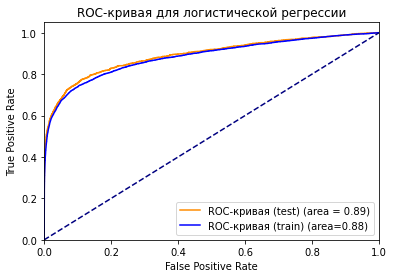

In [18]:
fpr_test, tpr_test, treshold_test = roc_curve(y_test, y_probs_test)
fpr_train, tpr_train, treshold_train = roc_curve(y_train, y_probs_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)
plt.plot(fpr_test, tpr_test, color='darkorange',
         label='ROC-кривая (test) (area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='blue', label='ROC-кривая (train) (area=%0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для логистической регрессии')
plt.legend(loc="lower right")
plt.show()

In [8]:
ece_score(y_test, y_probs)

0.07476797135021535

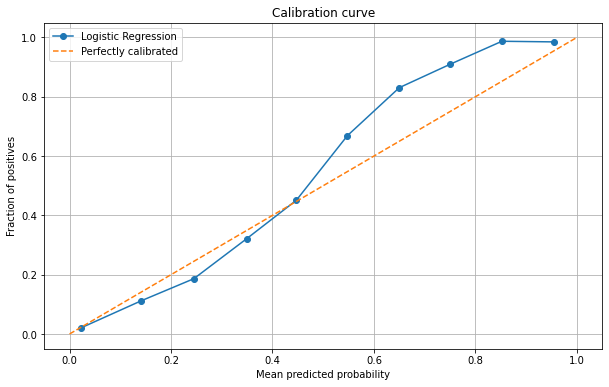

In [9]:
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [10]:
isotonic_clf = CalibratedClassifierCV(lr_model, cv=2, method="isotonic")
isotonic_clf.fit(X_test, y_test)
prob_pos_isotonic = isotonic_clf.predict_proba(X_test)[:, 1]

In [11]:
ece_score(y_test, prob_pos_isotonic)

0.02646725312541379

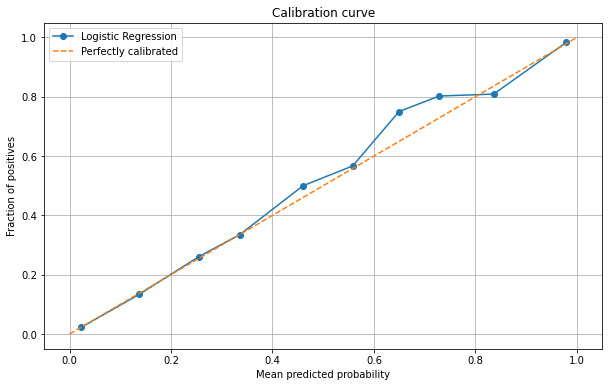

In [12]:
prob_true, prob_pred = calibration_curve(y_test, prob_pos_isotonic, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [19]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
print(classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     18506
           1       1.00      0.33      0.49      1494

    accuracy                           0.95     20000
   macro avg       0.97      0.66      0.73     20000
weighted avg       0.95      0.95      0.94     20000



In [20]:
roc_auc_score(y_test, y_probs_test := rf_model.predict_proba(X_test)[:, 1])

0.9456627800875319

In [22]:
roc_auc_score(y_train, y_probs_train := rf_model.predict_proba(X_train)[:, 1])

1.0

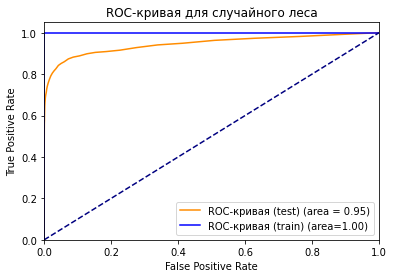

In [23]:
fpr_test, tpr_test, treshold_test = roc_curve(y_test, y_probs_test)
fpr_train, tpr_train, treshold_train = roc_curve(y_train, y_probs_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)
plt.plot(fpr_test, tpr_test, color='darkorange',
         label='ROC-кривая (test) (area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='blue', label='ROC-кривая (train) (area=%0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для случайного леса')
plt.legend(loc="lower right")
plt.show()

In [17]:
ece_score(y_test, y_probs)

0.24889363924911004

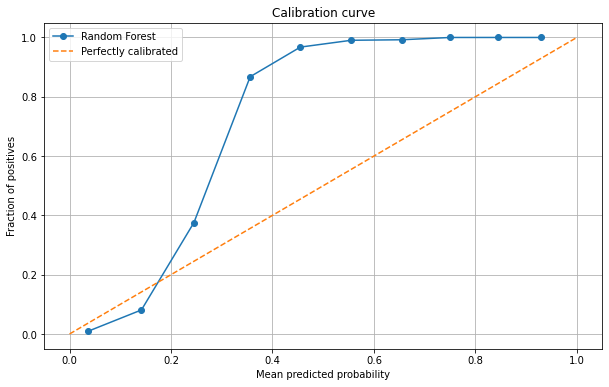

In [18]:
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [19]:
isotonic_clf = CalibratedClassifierCV(rf_model, cv=2, method="isotonic")
isotonic_clf.fit(X_test, y_test)
prob_pos_isotonic = isotonic_clf.predict_proba(X_test)[:, 1]

In [20]:
ece_score(y_test, prob_pos_isotonic)

0.23999500448283773

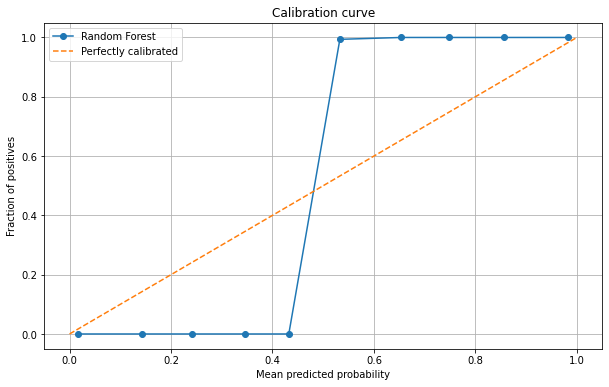

In [21]:
prob_true, prob_pred = calibration_curve(y_test, prob_pos_isotonic, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [24]:
catboost_model = CatBoostClassifier(task_type='GPU')
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)
catboost_model.fit(X_train, y_train, plot=True, use_best_model=True)
print(classification_report(y_test, catboost_model.predict(X_test)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.026491
0:	learn: 0.6576841	total: 89.8ms	remaining: 1m 29s
1:	learn: 0.6250186	total: 96.1ms	remaining: 48s
2:	learn: 0.5942824	total: 102ms	remaining: 33.9s
3:	learn: 0.5665566	total: 108ms	remaining: 26.9s
4:	learn: 0.5395388	total: 114ms	remaining: 22.8s
5:	learn: 0.5148433	total: 120ms	remaining: 20s
6:	learn: 0.4916664	total: 126ms	remaining: 17.9s
7:	learn: 0.4711612	total: 133ms	remaining: 16.5s
8:	learn: 0.4517669	total: 139ms	remaining: 15.3s
9:	learn: 0.4350802	total: 145ms	remaining: 14.3s
10:	learn: 0.4188980	total: 152ms	remaining: 13.6s
11:	learn: 0.4033604	total: 158ms	remaining: 13s
12:	learn: 0.3890074	total: 164ms	remaining: 12.5s
13:	learn: 0.3763113	total: 170ms	remaining: 12s
14:	learn: 0.3633302	total: 177ms	remaining: 11.6s
15:	learn: 0.3517230	total: 183ms	remaining: 11.3s
16:	learn: 0.3404896	total: 190ms	remaining: 11s
17:	learn: 0.3305701	total: 196ms	remaining: 10.7s
18:	learn: 0.3213926	total: 203ms	remaining: 10.5s
19:	learn: 0.31276

186:	learn: 0.1241279	total: 1.36s	remaining: 5.91s
187:	learn: 0.1238835	total: 1.37s	remaining: 5.91s
188:	learn: 0.1236179	total: 1.37s	remaining: 5.89s
189:	learn: 0.1233567	total: 1.38s	remaining: 5.88s
190:	learn: 0.1230409	total: 1.39s	remaining: 5.87s
191:	learn: 0.1228039	total: 1.39s	remaining: 5.86s
192:	learn: 0.1224842	total: 1.4s	remaining: 5.85s
193:	learn: 0.1223068	total: 1.41s	remaining: 5.85s
194:	learn: 0.1220547	total: 1.41s	remaining: 5.84s
195:	learn: 0.1218475	total: 1.42s	remaining: 5.83s
196:	learn: 0.1216370	total: 1.43s	remaining: 5.81s
197:	learn: 0.1213903	total: 1.43s	remaining: 5.8s
198:	learn: 0.1211504	total: 1.44s	remaining: 5.79s
199:	learn: 0.1208934	total: 1.44s	remaining: 5.78s
200:	learn: 0.1206091	total: 1.45s	remaining: 5.76s
201:	learn: 0.1203329	total: 1.46s	remaining: 5.75s
202:	learn: 0.1200770	total: 1.46s	remaining: 5.74s
203:	learn: 0.1197980	total: 1.47s	remaining: 5.73s
204:	learn: 0.1195457	total: 1.48s	remaining: 5.72s
205:	learn: 0.

357:	learn: 0.0933440	total: 2.64s	remaining: 4.74s
358:	learn: 0.0932310	total: 2.65s	remaining: 4.73s
359:	learn: 0.0930947	total: 2.65s	remaining: 4.72s
360:	learn: 0.0929433	total: 2.66s	remaining: 4.71s
361:	learn: 0.0928219	total: 2.67s	remaining: 4.7s
362:	learn: 0.0927090	total: 2.67s	remaining: 4.7s
363:	learn: 0.0926071	total: 2.68s	remaining: 4.68s
364:	learn: 0.0924711	total: 2.69s	remaining: 4.68s
365:	learn: 0.0923491	total: 2.69s	remaining: 4.67s
366:	learn: 0.0922436	total: 2.7s	remaining: 4.66s
367:	learn: 0.0920849	total: 2.71s	remaining: 4.65s
368:	learn: 0.0919914	total: 2.71s	remaining: 4.64s
369:	learn: 0.0918496	total: 2.72s	remaining: 4.63s
370:	learn: 0.0917397	total: 2.73s	remaining: 4.62s
371:	learn: 0.0916074	total: 2.73s	remaining: 4.61s
372:	learn: 0.0914740	total: 2.74s	remaining: 4.61s
373:	learn: 0.0913581	total: 2.75s	remaining: 4.6s
374:	learn: 0.0912362	total: 2.75s	remaining: 4.59s
375:	learn: 0.0911521	total: 2.76s	remaining: 4.58s
376:	learn: 0.09

520:	learn: 0.0777398	total: 3.7s	remaining: 3.4s
521:	learn: 0.0776749	total: 3.71s	remaining: 3.4s
522:	learn: 0.0775912	total: 3.72s	remaining: 3.39s
523:	learn: 0.0775287	total: 3.72s	remaining: 3.38s
524:	learn: 0.0774939	total: 3.73s	remaining: 3.37s
525:	learn: 0.0774036	total: 3.73s	remaining: 3.37s
526:	learn: 0.0773604	total: 3.74s	remaining: 3.36s
527:	learn: 0.0772717	total: 3.75s	remaining: 3.35s
528:	learn: 0.0772081	total: 3.75s	remaining: 3.34s
529:	learn: 0.0771472	total: 3.76s	remaining: 3.34s
530:	learn: 0.0770992	total: 3.77s	remaining: 3.33s
531:	learn: 0.0770333	total: 3.77s	remaining: 3.32s
532:	learn: 0.0769704	total: 3.78s	remaining: 3.31s
533:	learn: 0.0768942	total: 3.79s	remaining: 3.31s
534:	learn: 0.0768057	total: 3.79s	remaining: 3.3s
535:	learn: 0.0767358	total: 3.8s	remaining: 3.29s
536:	learn: 0.0766850	total: 3.81s	remaining: 3.28s
537:	learn: 0.0765891	total: 3.81s	remaining: 3.27s
538:	learn: 0.0765245	total: 3.82s	remaining: 3.27s
539:	learn: 0.076

685:	learn: 0.0684517	total: 4.77s	remaining: 2.18s
686:	learn: 0.0684303	total: 4.78s	remaining: 2.18s
687:	learn: 0.0683686	total: 4.79s	remaining: 2.17s
688:	learn: 0.0682994	total: 4.8s	remaining: 2.17s
689:	learn: 0.0682592	total: 4.81s	remaining: 2.16s
690:	learn: 0.0682301	total: 4.83s	remaining: 2.16s
691:	learn: 0.0681882	total: 4.84s	remaining: 2.15s
692:	learn: 0.0681383	total: 4.85s	remaining: 2.15s
693:	learn: 0.0680922	total: 4.86s	remaining: 2.14s
694:	learn: 0.0680242	total: 4.87s	remaining: 2.14s
695:	learn: 0.0679734	total: 4.88s	remaining: 2.13s
696:	learn: 0.0679393	total: 4.88s	remaining: 2.12s
697:	learn: 0.0678918	total: 4.89s	remaining: 2.11s
698:	learn: 0.0678368	total: 4.89s	remaining: 2.11s
699:	learn: 0.0678236	total: 4.9s	remaining: 2.1s
700:	learn: 0.0677892	total: 4.91s	remaining: 2.09s
701:	learn: 0.0677397	total: 4.91s	remaining: 2.08s
702:	learn: 0.0677108	total: 4.92s	remaining: 2.08s
703:	learn: 0.0676667	total: 4.92s	remaining: 2.07s
704:	learn: 0.0

868:	learn: 0.0620886	total: 6.01s	remaining: 906ms
869:	learn: 0.0620539	total: 6.03s	remaining: 901ms
870:	learn: 0.0620113	total: 6.04s	remaining: 895ms
871:	learn: 0.0619972	total: 6.05s	remaining: 888ms
872:	learn: 0.0619877	total: 6.06s	remaining: 881ms
873:	learn: 0.0619463	total: 6.07s	remaining: 875ms
874:	learn: 0.0619292	total: 6.08s	remaining: 868ms
875:	learn: 0.0619124	total: 6.08s	remaining: 861ms
876:	learn: 0.0618603	total: 6.09s	remaining: 854ms
877:	learn: 0.0618509	total: 6.1s	remaining: 847ms
878:	learn: 0.0618385	total: 6.1s	remaining: 840ms
879:	learn: 0.0618088	total: 6.11s	remaining: 833ms
880:	learn: 0.0617687	total: 6.12s	remaining: 826ms
881:	learn: 0.0617425	total: 6.12s	remaining: 819ms
882:	learn: 0.0617301	total: 6.13s	remaining: 812ms
883:	learn: 0.0616988	total: 6.14s	remaining: 805ms
884:	learn: 0.0616778	total: 6.14s	remaining: 798ms
885:	learn: 0.0616538	total: 6.15s	remaining: 791ms
886:	learn: 0.0616330	total: 6.16s	remaining: 784ms
887:	learn: 0.

In [25]:
roc_auc_score(y_test, y_probs_test := catboost_model.predict_proba(X_test)[:, 1])

0.9593572604478217

In [26]:
roc_auc_score(y_train, y_probs_train := catboost_model.predict_proba(X_train)[:, 1])

0.9790028688148158

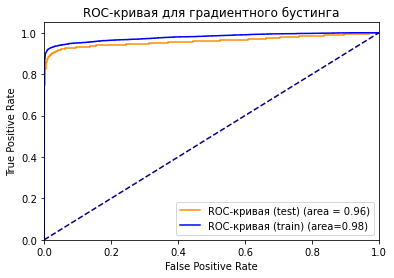

In [27]:
fpr_test, tpr_test, treshold_test = roc_curve(y_test, y_probs_test)
fpr_train, tpr_train, treshold_train = roc_curve(y_train, y_probs_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)
plt.plot(fpr_test, tpr_test, color='darkorange',
         label='ROC-кривая (test) (area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='blue', label='ROC-кривая (train) (area=%0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для градиентного бустинга')
plt.legend(loc="lower right")
plt.show()

In [24]:
ece_score(y_test, y_probs)

0.1812101684864241

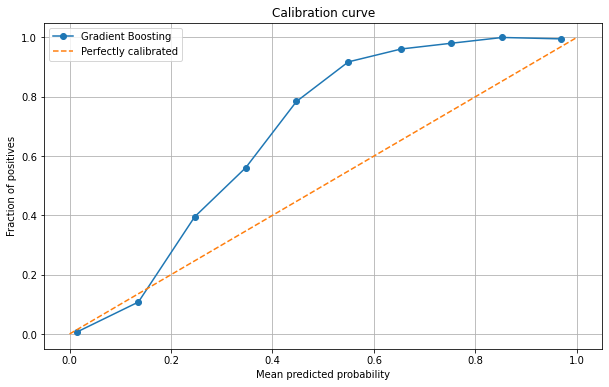

In [25]:
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Gradient Boosting')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [26]:
isotonic_clf = CalibratedClassifierCV(catboost_model, cv=2, method="isotonic")
isotonic_clf.fit(X_test, y_test)
prob_pos_isotonic = isotonic_clf.predict_proba(X_test)[:, 1]

Learning rate set to 0.029701
0:	learn: 0.6489241	total: 32.4ms	remaining: 32.4s
1:	learn: 0.6134459	total: 60.2ms	remaining: 30.1s
2:	learn: 0.5771916	total: 88.7ms	remaining: 29.5s
3:	learn: 0.5464996	total: 118ms	remaining: 29.4s
4:	learn: 0.5173799	total: 145ms	remaining: 28.9s
5:	learn: 0.4927558	total: 173ms	remaining: 28.7s
6:	learn: 0.4699067	total: 202ms	remaining: 28.7s
7:	learn: 0.4479920	total: 230ms	remaining: 28.5s
8:	learn: 0.4291080	total: 257ms	remaining: 28.3s
9:	learn: 0.4097464	total: 285ms	remaining: 28.2s
10:	learn: 0.3924647	total: 315ms	remaining: 28.3s
11:	learn: 0.3774992	total: 342ms	remaining: 28.2s
12:	learn: 0.3614436	total: 370ms	remaining: 28.1s
13:	learn: 0.3487543	total: 398ms	remaining: 28.1s
14:	learn: 0.3362457	total: 427ms	remaining: 28s
15:	learn: 0.3245383	total: 454ms	remaining: 27.9s
16:	learn: 0.3146006	total: 480ms	remaining: 27.8s
17:	learn: 0.3049400	total: 503ms	remaining: 27.4s
18:	learn: 0.2965707	total: 530ms	remaining: 27.3s
19:	learn:

161:	learn: 0.1061045	total: 4.65s	remaining: 24.1s
162:	learn: 0.1057155	total: 4.68s	remaining: 24s
163:	learn: 0.1054635	total: 4.71s	remaining: 24s
164:	learn: 0.1050867	total: 4.73s	remaining: 24s
165:	learn: 0.1047613	total: 4.76s	remaining: 23.9s
166:	learn: 0.1044604	total: 4.79s	remaining: 23.9s
167:	learn: 0.1041280	total: 4.81s	remaining: 23.8s
168:	learn: 0.1038654	total: 4.84s	remaining: 23.8s
169:	learn: 0.1034871	total: 4.87s	remaining: 23.8s
170:	learn: 0.1030129	total: 4.9s	remaining: 23.7s
171:	learn: 0.1027798	total: 4.92s	remaining: 23.7s
172:	learn: 0.1025425	total: 4.95s	remaining: 23.7s
173:	learn: 0.1023214	total: 4.98s	remaining: 23.7s
174:	learn: 0.1021147	total: 5.01s	remaining: 23.6s
175:	learn: 0.1017576	total: 5.04s	remaining: 23.6s
176:	learn: 0.1011686	total: 5.07s	remaining: 23.6s
177:	learn: 0.1009404	total: 5.1s	remaining: 23.5s
178:	learn: 0.1004684	total: 5.13s	remaining: 23.5s
179:	learn: 0.1001249	total: 5.15s	remaining: 23.5s
180:	learn: 0.099667

327:	learn: 0.0691280	total: 9.28s	remaining: 19s
328:	learn: 0.0689812	total: 9.31s	remaining: 19s
329:	learn: 0.0688747	total: 9.34s	remaining: 19s
330:	learn: 0.0687974	total: 9.36s	remaining: 18.9s
331:	learn: 0.0686861	total: 9.39s	remaining: 18.9s
332:	learn: 0.0685632	total: 9.42s	remaining: 18.9s
333:	learn: 0.0684680	total: 9.45s	remaining: 18.8s
334:	learn: 0.0683844	total: 9.47s	remaining: 18.8s
335:	learn: 0.0683152	total: 9.5s	remaining: 18.8s
336:	learn: 0.0681688	total: 9.53s	remaining: 18.7s
337:	learn: 0.0680502	total: 9.55s	remaining: 18.7s
338:	learn: 0.0678815	total: 9.58s	remaining: 18.7s
339:	learn: 0.0675895	total: 9.61s	remaining: 18.7s
340:	learn: 0.0673376	total: 9.64s	remaining: 18.6s
341:	learn: 0.0672868	total: 9.66s	remaining: 18.6s
342:	learn: 0.0671099	total: 9.69s	remaining: 18.6s
343:	learn: 0.0670123	total: 9.72s	remaining: 18.5s
344:	learn: 0.0669370	total: 9.75s	remaining: 18.5s
345:	learn: 0.0668485	total: 9.78s	remaining: 18.5s
346:	learn: 0.06664

487:	learn: 0.0509217	total: 13.7s	remaining: 14.4s
488:	learn: 0.0508750	total: 13.7s	remaining: 14.3s
489:	learn: 0.0507806	total: 13.7s	remaining: 14.3s
490:	learn: 0.0506448	total: 13.8s	remaining: 14.3s
491:	learn: 0.0505123	total: 13.8s	remaining: 14.2s
492:	learn: 0.0504692	total: 13.8s	remaining: 14.2s
493:	learn: 0.0503279	total: 13.9s	remaining: 14.2s
494:	learn: 0.0502960	total: 13.9s	remaining: 14.2s
495:	learn: 0.0502533	total: 13.9s	remaining: 14.1s
496:	learn: 0.0501485	total: 13.9s	remaining: 14.1s
497:	learn: 0.0500426	total: 14s	remaining: 14.1s
498:	learn: 0.0498872	total: 14s	remaining: 14s
499:	learn: 0.0497573	total: 14s	remaining: 14s
500:	learn: 0.0496349	total: 14s	remaining: 14s
501:	learn: 0.0494823	total: 14.1s	remaining: 14s
502:	learn: 0.0494209	total: 14.1s	remaining: 13.9s
503:	learn: 0.0493630	total: 14.1s	remaining: 13.9s
504:	learn: 0.0492344	total: 14.2s	remaining: 13.9s
505:	learn: 0.0491095	total: 14.2s	remaining: 13.8s
506:	learn: 0.0490678	total:

647:	learn: 0.0391171	total: 18.1s	remaining: 9.82s
648:	learn: 0.0390307	total: 18.1s	remaining: 9.79s
649:	learn: 0.0389655	total: 18.1s	remaining: 9.76s
650:	learn: 0.0389198	total: 18.2s	remaining: 9.73s
651:	learn: 0.0388547	total: 18.2s	remaining: 9.71s
652:	learn: 0.0387587	total: 18.2s	remaining: 9.68s
653:	learn: 0.0386821	total: 18.2s	remaining: 9.65s
654:	learn: 0.0386140	total: 18.3s	remaining: 9.62s
655:	learn: 0.0385075	total: 18.3s	remaining: 9.59s
656:	learn: 0.0384755	total: 18.3s	remaining: 9.56s
657:	learn: 0.0383976	total: 18.3s	remaining: 9.54s
658:	learn: 0.0383614	total: 18.4s	remaining: 9.51s
659:	learn: 0.0383053	total: 18.4s	remaining: 9.48s
660:	learn: 0.0382134	total: 18.4s	remaining: 9.45s
661:	learn: 0.0381384	total: 18.5s	remaining: 9.42s
662:	learn: 0.0380529	total: 18.5s	remaining: 9.4s
663:	learn: 0.0380005	total: 18.5s	remaining: 9.37s
664:	learn: 0.0379528	total: 18.5s	remaining: 9.34s
665:	learn: 0.0378973	total: 18.6s	remaining: 9.31s
666:	learn: 0

807:	learn: 0.0309318	total: 22.5s	remaining: 5.33s
808:	learn: 0.0308949	total: 22.5s	remaining: 5.31s
809:	learn: 0.0308532	total: 22.5s	remaining: 5.28s
810:	learn: 0.0308065	total: 22.5s	remaining: 5.25s
811:	learn: 0.0307693	total: 22.6s	remaining: 5.22s
812:	learn: 0.0307079	total: 22.6s	remaining: 5.2s
813:	learn: 0.0306709	total: 22.6s	remaining: 5.17s
814:	learn: 0.0305952	total: 22.6s	remaining: 5.14s
815:	learn: 0.0304998	total: 22.7s	remaining: 5.11s
816:	learn: 0.0304796	total: 22.7s	remaining: 5.08s
817:	learn: 0.0304301	total: 22.7s	remaining: 5.06s
818:	learn: 0.0303590	total: 22.8s	remaining: 5.03s
819:	learn: 0.0303001	total: 22.8s	remaining: 5s
820:	learn: 0.0302758	total: 22.8s	remaining: 4.97s
821:	learn: 0.0302620	total: 22.8s	remaining: 4.95s
822:	learn: 0.0302209	total: 22.9s	remaining: 4.92s
823:	learn: 0.0301526	total: 22.9s	remaining: 4.89s
824:	learn: 0.0300874	total: 22.9s	remaining: 4.86s
825:	learn: 0.0300234	total: 23s	remaining: 4.83s
826:	learn: 0.0300

972:	learn: 0.0242253	total: 27.1s	remaining: 751ms
973:	learn: 0.0241836	total: 27.1s	remaining: 723ms
974:	learn: 0.0241196	total: 27.1s	remaining: 695ms
975:	learn: 0.0240548	total: 27.1s	remaining: 668ms
976:	learn: 0.0240268	total: 27.2s	remaining: 640ms
977:	learn: 0.0239689	total: 27.2s	remaining: 612ms
978:	learn: 0.0239033	total: 27.2s	remaining: 584ms
979:	learn: 0.0238844	total: 27.3s	remaining: 556ms
980:	learn: 0.0238510	total: 27.3s	remaining: 528ms
981:	learn: 0.0238149	total: 27.3s	remaining: 501ms
982:	learn: 0.0237664	total: 27.3s	remaining: 473ms
983:	learn: 0.0236812	total: 27.4s	remaining: 445ms
984:	learn: 0.0236171	total: 27.4s	remaining: 417ms
985:	learn: 0.0235743	total: 27.4s	remaining: 389ms
986:	learn: 0.0235252	total: 27.5s	remaining: 362ms
987:	learn: 0.0234942	total: 27.5s	remaining: 334ms
988:	learn: 0.0234570	total: 27.5s	remaining: 306ms
989:	learn: 0.0234079	total: 27.6s	remaining: 278ms
990:	learn: 0.0233793	total: 27.6s	remaining: 251ms
991:	learn: 

134:	learn: 0.1251303	total: 3.73s	remaining: 23.9s
135:	learn: 0.1245738	total: 3.76s	remaining: 23.9s
136:	learn: 0.1243257	total: 3.79s	remaining: 23.9s
137:	learn: 0.1239185	total: 3.82s	remaining: 23.9s
138:	learn: 0.1235853	total: 3.85s	remaining: 23.9s
139:	learn: 0.1231782	total: 3.89s	remaining: 23.9s
140:	learn: 0.1225294	total: 3.92s	remaining: 23.9s
141:	learn: 0.1221302	total: 3.95s	remaining: 23.9s
142:	learn: 0.1218823	total: 3.98s	remaining: 23.8s
143:	learn: 0.1213774	total: 4.01s	remaining: 23.8s
144:	learn: 0.1209446	total: 4.04s	remaining: 23.8s
145:	learn: 0.1203948	total: 4.06s	remaining: 23.8s
146:	learn: 0.1200898	total: 4.09s	remaining: 23.7s
147:	learn: 0.1195489	total: 4.12s	remaining: 23.7s
148:	learn: 0.1189508	total: 4.14s	remaining: 23.7s
149:	learn: 0.1187557	total: 4.17s	remaining: 23.6s
150:	learn: 0.1183994	total: 4.2s	remaining: 23.6s
151:	learn: 0.1181162	total: 4.23s	remaining: 23.6s
152:	learn: 0.1178783	total: 4.25s	remaining: 23.5s
153:	learn: 0

294:	learn: 0.0831550	total: 8.39s	remaining: 20.1s
295:	learn: 0.0829504	total: 8.42s	remaining: 20s
296:	learn: 0.0828222	total: 8.45s	remaining: 20s
297:	learn: 0.0826077	total: 8.47s	remaining: 20s
298:	learn: 0.0825121	total: 8.5s	remaining: 19.9s
299:	learn: 0.0823457	total: 8.53s	remaining: 19.9s
300:	learn: 0.0820503	total: 8.55s	remaining: 19.9s
301:	learn: 0.0818403	total: 8.58s	remaining: 19.8s
302:	learn: 0.0817282	total: 8.61s	remaining: 19.8s
303:	learn: 0.0815631	total: 8.63s	remaining: 19.8s
304:	learn: 0.0814609	total: 8.66s	remaining: 19.7s
305:	learn: 0.0811676	total: 8.7s	remaining: 19.7s
306:	learn: 0.0811366	total: 8.72s	remaining: 19.7s
307:	learn: 0.0810047	total: 8.75s	remaining: 19.7s
308:	learn: 0.0808503	total: 8.79s	remaining: 19.6s
309:	learn: 0.0807232	total: 8.81s	remaining: 19.6s
310:	learn: 0.0806399	total: 8.85s	remaining: 19.6s
311:	learn: 0.0805231	total: 8.88s	remaining: 19.6s
312:	learn: 0.0803368	total: 8.9s	remaining: 19.5s
313:	learn: 0.0801575

457:	learn: 0.0595593	total: 13.1s	remaining: 15.4s
458:	learn: 0.0595136	total: 13.1s	remaining: 15.4s
459:	learn: 0.0594273	total: 13.1s	remaining: 15.4s
460:	learn: 0.0593083	total: 13.1s	remaining: 15.4s
461:	learn: 0.0591470	total: 13.2s	remaining: 15.3s
462:	learn: 0.0591072	total: 13.2s	remaining: 15.3s
463:	learn: 0.0589707	total: 13.2s	remaining: 15.3s
464:	learn: 0.0589284	total: 13.2s	remaining: 15.2s
465:	learn: 0.0588476	total: 13.3s	remaining: 15.2s
466:	learn: 0.0587516	total: 13.3s	remaining: 15.2s
467:	learn: 0.0586406	total: 13.3s	remaining: 15.2s
468:	learn: 0.0585281	total: 13.4s	remaining: 15.1s
469:	learn: 0.0584494	total: 13.4s	remaining: 15.1s
470:	learn: 0.0583612	total: 13.4s	remaining: 15.1s
471:	learn: 0.0582782	total: 13.4s	remaining: 15s
472:	learn: 0.0582208	total: 13.5s	remaining: 15s
473:	learn: 0.0580606	total: 13.5s	remaining: 15s
474:	learn: 0.0578970	total: 13.5s	remaining: 14.9s
475:	learn: 0.0578080	total: 13.5s	remaining: 14.9s
476:	learn: 0.0577

623:	learn: 0.0457421	total: 17.9s	remaining: 10.8s
624:	learn: 0.0456883	total: 18s	remaining: 10.8s
625:	learn: 0.0456021	total: 18s	remaining: 10.8s
626:	learn: 0.0455584	total: 18s	remaining: 10.7s
627:	learn: 0.0455298	total: 18.1s	remaining: 10.7s
628:	learn: 0.0454750	total: 18.1s	remaining: 10.7s
629:	learn: 0.0453265	total: 18.1s	remaining: 10.6s
630:	learn: 0.0452491	total: 18.2s	remaining: 10.6s
631:	learn: 0.0451532	total: 18.2s	remaining: 10.6s
632:	learn: 0.0451316	total: 18.2s	remaining: 10.6s
633:	learn: 0.0451053	total: 18.3s	remaining: 10.5s
634:	learn: 0.0450619	total: 18.3s	remaining: 10.5s
635:	learn: 0.0449839	total: 18.3s	remaining: 10.5s
636:	learn: 0.0448896	total: 18.3s	remaining: 10.5s
637:	learn: 0.0448031	total: 18.4s	remaining: 10.4s
638:	learn: 0.0447293	total: 18.4s	remaining: 10.4s
639:	learn: 0.0446482	total: 18.4s	remaining: 10.4s
640:	learn: 0.0445376	total: 18.5s	remaining: 10.3s
641:	learn: 0.0444674	total: 18.5s	remaining: 10.3s
642:	learn: 0.0444

782:	learn: 0.0359497	total: 22.5s	remaining: 6.24s
783:	learn: 0.0359086	total: 22.5s	remaining: 6.21s
784:	learn: 0.0358202	total: 22.6s	remaining: 6.18s
785:	learn: 0.0357752	total: 22.6s	remaining: 6.15s
786:	learn: 0.0357448	total: 22.6s	remaining: 6.12s
787:	learn: 0.0356600	total: 22.7s	remaining: 6.09s
788:	learn: 0.0356023	total: 22.7s	remaining: 6.07s
789:	learn: 0.0355559	total: 22.7s	remaining: 6.04s
790:	learn: 0.0355137	total: 22.7s	remaining: 6.01s
791:	learn: 0.0354736	total: 22.8s	remaining: 5.98s
792:	learn: 0.0354014	total: 22.8s	remaining: 5.95s
793:	learn: 0.0353500	total: 22.8s	remaining: 5.92s
794:	learn: 0.0353025	total: 22.9s	remaining: 5.89s
795:	learn: 0.0352104	total: 22.9s	remaining: 5.87s
796:	learn: 0.0351454	total: 22.9s	remaining: 5.84s
797:	learn: 0.0350791	total: 22.9s	remaining: 5.81s
798:	learn: 0.0349926	total: 23s	remaining: 5.78s
799:	learn: 0.0349479	total: 23s	remaining: 5.75s
800:	learn: 0.0349283	total: 23s	remaining: 5.72s
801:	learn: 0.0348

941:	learn: 0.0286995	total: 26.9s	remaining: 1.66s
942:	learn: 0.0286584	total: 26.9s	remaining: 1.63s
943:	learn: 0.0286166	total: 27s	remaining: 1.6s
944:	learn: 0.0285807	total: 27s	remaining: 1.57s
945:	learn: 0.0285459	total: 27s	remaining: 1.54s
946:	learn: 0.0285141	total: 27.1s	remaining: 1.51s
947:	learn: 0.0284851	total: 27.1s	remaining: 1.49s
948:	learn: 0.0284266	total: 27.1s	remaining: 1.46s
949:	learn: 0.0283677	total: 27.1s	remaining: 1.43s
950:	learn: 0.0283580	total: 27.2s	remaining: 1.4s
951:	learn: 0.0282975	total: 27.2s	remaining: 1.37s
952:	learn: 0.0282522	total: 27.2s	remaining: 1.34s
953:	learn: 0.0282283	total: 27.2s	remaining: 1.31s
954:	learn: 0.0282016	total: 27.3s	remaining: 1.28s
955:	learn: 0.0281623	total: 27.3s	remaining: 1.26s
956:	learn: 0.0281342	total: 27.3s	remaining: 1.23s
957:	learn: 0.0281124	total: 27.4s	remaining: 1.2s
958:	learn: 0.0280507	total: 27.4s	remaining: 1.17s
959:	learn: 0.0280188	total: 27.4s	remaining: 1.14s
960:	learn: 0.0279387

In [27]:
ece_score(y_test, prob_pos_isotonic)

0.14706083405528492

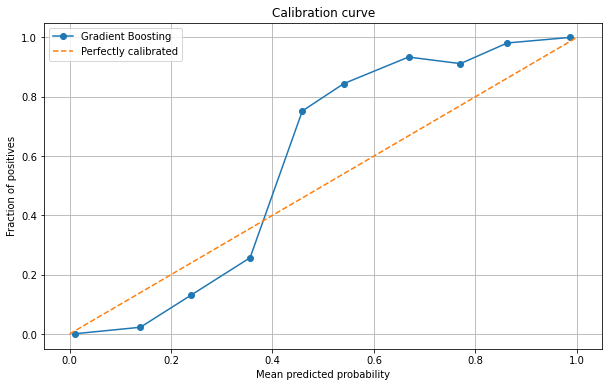

In [28]:
prob_true, prob_pred = calibration_curve(y_test, prob_pos_isotonic, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Gradient Boosting')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

Лучше всего откалибрована модель логистической регрессии => используем её результаты

In [159]:
result = {'client_id': range(n_items := test_df.shape[0]),
          'product': ['credit card'] * n_items,
          'channel': ['call'] * n_items,
          'score': list(prob_pos_isotonic)}

result_df = pd.DataFrame(result)
result_df.to_csv('credit_card_call_result.csv')

# Модель для кредитных карт (СМС)

In [28]:
train_df = pd.read_csv('marketing_optimization_data/credit_card_sms_train.csv')
test_df = pd.read_csv('marketing_optimization_data/credit_card_sms_oot.csv')

In [29]:
X_train, y_train = train_df.drop(['target'], axis=1), train_df['target']
X_test, y_test = test_df.drop(['target'], axis=1), test_df['target']

In [30]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
print(classification_report(y_test, lr_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19107
           1       0.88      0.48      0.62       893

    accuracy                           0.97     20000
   macro avg       0.93      0.74      0.80     20000
weighted avg       0.97      0.97      0.97     20000



In [31]:
roc_auc_score(y_test, y_probs_test := lr_model.predict_proba(X_test)[:, 1])

0.9122917200364706

In [32]:
roc_auc_score(y_train, y_probs_train := lr_model.predict_proba(X_train)[:, 1])

0.9145444051250184

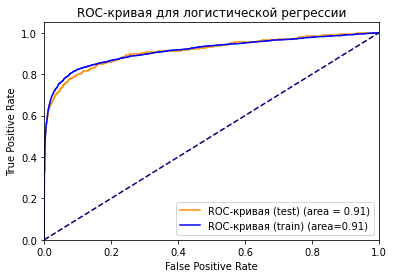

In [33]:
fpr_test, tpr_test, treshold_test = roc_curve(y_test, y_probs_test)
fpr_train, tpr_train, treshold_train = roc_curve(y_train, y_probs_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)
plt.plot(fpr_test, tpr_test, color='darkorange',
         label='ROC-кривая (test) (area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='blue', label='ROC-кривая (train) (area=%0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для логистической регрессии')
plt.legend(loc="lower right")
plt.show()

In [33]:
ece_score(y_test, y_probs)

0.07591990858109444

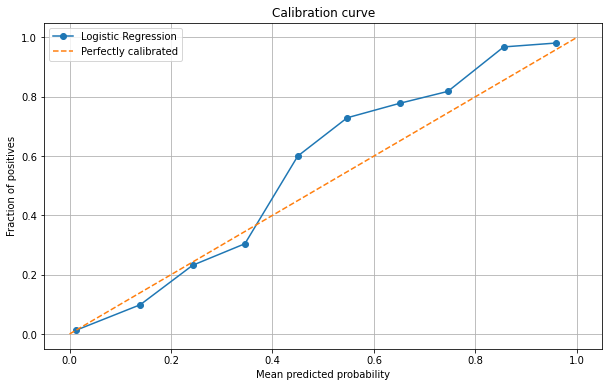

In [34]:
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [35]:
isotonic_clf = CalibratedClassifierCV(lr_model, cv=2, method="isotonic")
isotonic_clf.fit(X_test, y_test)
prob_pos_isotonic = isotonic_clf.predict_proba(X_test)[:, 1]

In [36]:
ece_score(y_test, prob_pos_isotonic)

0.031658159192141946

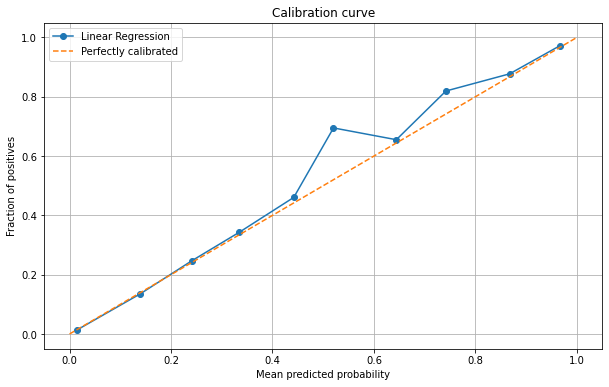

In [37]:
prob_true, prob_pred = calibration_curve(y_test, prob_pos_isotonic, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Linear Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [34]:
rf_model = RandomForestClassifier(n_jobs=-1)
rf_model.fit(X_train, y_train)
print(classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     19107
           1       1.00      0.23      0.37       893

    accuracy                           0.97     20000
   macro avg       0.98      0.61      0.67     20000
weighted avg       0.97      0.97      0.95     20000



In [35]:
roc_auc_score(y_test, y_probs_test := rf_model.predict_proba(X_test)[:, 1])

0.9247911698549648

In [36]:
roc_auc_score(y_train, y_probs_train := rf_model.predict_proba(X_train)[:, 1])

1.0

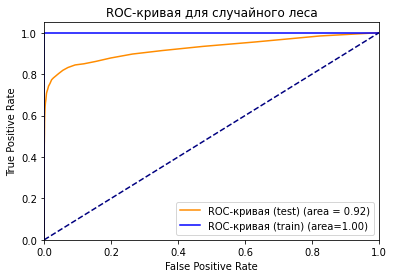

In [38]:
fpr_test, tpr_test, treshold_test = roc_curve(y_test, y_probs_test)
fpr_train, tpr_train, treshold_train = roc_curve(y_train, y_probs_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)
plt.plot(fpr_test, tpr_test, color='darkorange',
         label='ROC-кривая (test) (area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='blue', label='ROC-кривая (train) (area=%0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для случайного леса')
plt.legend(loc="lower right")
plt.show()

In [40]:
ece_score(y_test, y_probs)

0.27057152248386246

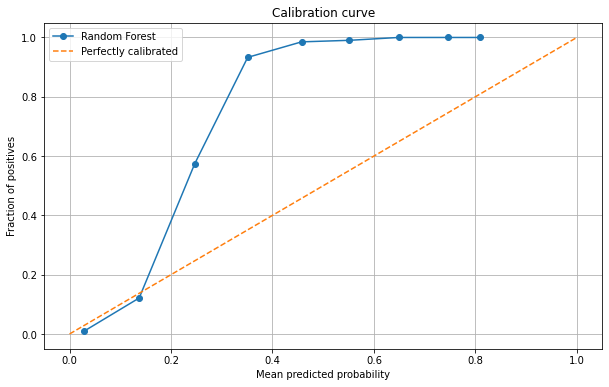

In [41]:
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [42]:
isotonic_clf = CalibratedClassifierCV(rf_model, cv=2, method="isotonic")
isotonic_clf.fit(X_test, y_test)
prob_pos_isotonic = isotonic_clf.predict_proba(X_test)[:, 1]

In [43]:
ece_score(y_test, prob_pos_isotonic)

0.241602315650142

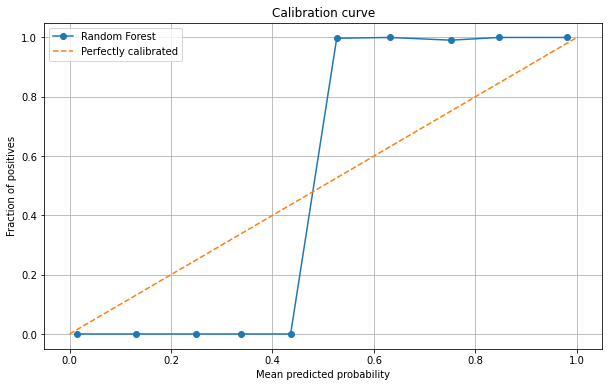

In [44]:
prob_true, prob_pred = calibration_curve(y_test, prob_pos_isotonic, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [39]:
catboost_model = CatBoostClassifier(task_type='GPU')
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)
catboost_model.fit(X_train, y_train, plot=True, use_best_model=False)
print(classification_report(y_test, catboost_model.predict(X_test)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.026491
0:	learn: 0.6502895	total: 6.6ms	remaining: 6.59s
1:	learn: 0.6092602	total: 13.4ms	remaining: 6.68s
2:	learn: 0.5730072	total: 19.3ms	remaining: 6.4s
3:	learn: 0.5393175	total: 25.3ms	remaining: 6.29s
4:	learn: 0.5086429	total: 31ms	remaining: 6.17s
5:	learn: 0.4811805	total: 37ms	remaining: 6.13s
6:	learn: 0.4554455	total: 43ms	remaining: 6.1s
7:	learn: 0.4314064	total: 48.7ms	remaining: 6.04s
8:	learn: 0.4084689	total: 55.4ms	remaining: 6.1s
9:	learn: 0.3888273	total: 61.9ms	remaining: 6.13s
10:	learn: 0.3690197	total: 68.8ms	remaining: 6.19s
11:	learn: 0.3507474	total: 75.7ms	remaining: 6.23s
12:	learn: 0.3349288	total: 82.4ms	remaining: 6.26s
13:	learn: 0.3198463	total: 89.3ms	remaining: 6.29s
14:	learn: 0.3064563	total: 95.8ms	remaining: 6.29s
15:	learn: 0.2936717	total: 102ms	remaining: 6.24s
16:	learn: 0.2823539	total: 108ms	remaining: 6.25s
17:	learn: 0.2715161	total: 117ms	remaining: 6.36s
18:	learn: 0.2609522	total: 123ms	remaining: 6.37s
19:	le

170:	learn: 0.0846768	total: 1.06s	remaining: 5.16s
171:	learn: 0.0844899	total: 1.07s	remaining: 5.17s
172:	learn: 0.0842792	total: 1.08s	remaining: 5.16s
173:	learn: 0.0840956	total: 1.09s	remaining: 5.16s
174:	learn: 0.0838766	total: 1.09s	remaining: 5.15s
175:	learn: 0.0836445	total: 1.1s	remaining: 5.16s
176:	learn: 0.0834342	total: 1.11s	remaining: 5.16s
177:	learn: 0.0832334	total: 1.12s	remaining: 5.16s
178:	learn: 0.0830633	total: 1.12s	remaining: 5.15s
179:	learn: 0.0828580	total: 1.13s	remaining: 5.14s
180:	learn: 0.0826626	total: 1.14s	remaining: 5.14s
181:	learn: 0.0824644	total: 1.14s	remaining: 5.13s
182:	learn: 0.0822723	total: 1.15s	remaining: 5.13s
183:	learn: 0.0820937	total: 1.16s	remaining: 5.12s
184:	learn: 0.0819268	total: 1.16s	remaining: 5.12s
185:	learn: 0.0817059	total: 1.17s	remaining: 5.11s
186:	learn: 0.0815516	total: 1.17s	remaining: 5.11s
187:	learn: 0.0814255	total: 1.18s	remaining: 5.1s
188:	learn: 0.0812265	total: 1.19s	remaining: 5.09s
189:	learn: 0.

356:	learn: 0.0629073	total: 2.32s	remaining: 4.18s
357:	learn: 0.0628591	total: 2.33s	remaining: 4.18s
358:	learn: 0.0627724	total: 2.34s	remaining: 4.17s
359:	learn: 0.0627140	total: 2.34s	remaining: 4.17s
360:	learn: 0.0626684	total: 2.35s	remaining: 4.16s
361:	learn: 0.0626084	total: 2.35s	remaining: 4.15s
362:	learn: 0.0625359	total: 2.36s	remaining: 4.14s
363:	learn: 0.0624846	total: 2.37s	remaining: 4.14s
364:	learn: 0.0623911	total: 2.37s	remaining: 4.13s
365:	learn: 0.0623313	total: 2.38s	remaining: 4.12s
366:	learn: 0.0622455	total: 2.39s	remaining: 4.12s
367:	learn: 0.0622056	total: 2.39s	remaining: 4.11s
368:	learn: 0.0621427	total: 2.4s	remaining: 4.1s
369:	learn: 0.0620683	total: 2.4s	remaining: 4.09s
370:	learn: 0.0619900	total: 2.41s	remaining: 4.09s
371:	learn: 0.0619272	total: 2.42s	remaining: 4.08s
372:	learn: 0.0618627	total: 2.42s	remaining: 4.08s
373:	learn: 0.0618020	total: 2.43s	remaining: 4.07s
374:	learn: 0.0617558	total: 2.44s	remaining: 4.06s
375:	learn: 0.0

520:	learn: 0.0542880	total: 3.4s	remaining: 3.12s
521:	learn: 0.0542621	total: 3.4s	remaining: 3.12s
522:	learn: 0.0542480	total: 3.41s	remaining: 3.11s
523:	learn: 0.0542292	total: 3.42s	remaining: 3.1s
524:	learn: 0.0542092	total: 3.42s	remaining: 3.1s
525:	learn: 0.0541590	total: 3.43s	remaining: 3.09s
526:	learn: 0.0541238	total: 3.43s	remaining: 3.08s
527:	learn: 0.0540907	total: 3.44s	remaining: 3.08s
528:	learn: 0.0540385	total: 3.45s	remaining: 3.07s
529:	learn: 0.0540106	total: 3.45s	remaining: 3.06s
530:	learn: 0.0539909	total: 3.46s	remaining: 3.06s
531:	learn: 0.0539443	total: 3.46s	remaining: 3.05s
532:	learn: 0.0538804	total: 3.47s	remaining: 3.04s
533:	learn: 0.0538023	total: 3.48s	remaining: 3.04s
534:	learn: 0.0537749	total: 3.49s	remaining: 3.03s
535:	learn: 0.0537654	total: 3.49s	remaining: 3.02s
536:	learn: 0.0537231	total: 3.5s	remaining: 3.02s
537:	learn: 0.0537044	total: 3.51s	remaining: 3.01s
538:	learn: 0.0536782	total: 3.51s	remaining: 3s
539:	learn: 0.053639

701:	learn: 0.0489233	total: 4.65s	remaining: 1.98s
702:	learn: 0.0488828	total: 4.66s	remaining: 1.97s
703:	learn: 0.0488514	total: 4.67s	remaining: 1.96s
704:	learn: 0.0488381	total: 4.67s	remaining: 1.96s
705:	learn: 0.0488108	total: 4.68s	remaining: 1.95s
706:	learn: 0.0487916	total: 4.69s	remaining: 1.94s
707:	learn: 0.0487578	total: 4.7s	remaining: 1.94s
708:	learn: 0.0487504	total: 4.7s	remaining: 1.93s
709:	learn: 0.0487413	total: 4.71s	remaining: 1.92s
710:	learn: 0.0487065	total: 4.71s	remaining: 1.92s
711:	learn: 0.0486665	total: 4.72s	remaining: 1.91s
712:	learn: 0.0486578	total: 4.73s	remaining: 1.9s
713:	learn: 0.0486468	total: 4.74s	remaining: 1.9s
714:	learn: 0.0486361	total: 4.74s	remaining: 1.89s
715:	learn: 0.0486250	total: 4.75s	remaining: 1.88s
716:	learn: 0.0486135	total: 4.75s	remaining: 1.88s
717:	learn: 0.0486025	total: 4.76s	remaining: 1.87s
718:	learn: 0.0485876	total: 4.77s	remaining: 1.86s
719:	learn: 0.0485728	total: 4.77s	remaining: 1.86s
720:	learn: 0.04

877:	learn: 0.0453940	total: 5.9s	remaining: 820ms
878:	learn: 0.0453771	total: 5.91s	remaining: 813ms
879:	learn: 0.0453705	total: 5.92s	remaining: 807ms
880:	learn: 0.0453317	total: 5.93s	remaining: 801ms
881:	learn: 0.0453065	total: 5.94s	remaining: 794ms
882:	learn: 0.0452984	total: 5.95s	remaining: 788ms
883:	learn: 0.0452857	total: 5.95s	remaining: 781ms
884:	learn: 0.0452718	total: 5.96s	remaining: 775ms
885:	learn: 0.0452527	total: 5.97s	remaining: 768ms
886:	learn: 0.0452370	total: 5.98s	remaining: 761ms
887:	learn: 0.0452133	total: 5.98s	remaining: 755ms
888:	learn: 0.0451977	total: 5.99s	remaining: 748ms
889:	learn: 0.0451856	total: 6s	remaining: 742ms
890:	learn: 0.0451523	total: 6.01s	remaining: 735ms
891:	learn: 0.0451316	total: 6.01s	remaining: 728ms
892:	learn: 0.0451237	total: 6.02s	remaining: 721ms
893:	learn: 0.0451075	total: 6.03s	remaining: 715ms
894:	learn: 0.0451007	total: 6.04s	remaining: 708ms
895:	learn: 0.0450917	total: 6.04s	remaining: 702ms
896:	learn: 0.04

In [40]:
roc_auc_score(y_test, y_probs_test := catboost_model.predict_proba(X_test)[:, 1])

0.9467407306211129

In [41]:
roc_auc_score(y_train, y_probs_train := catboost_model.predict_proba(X_train)[:, 1])

0.9735933494664888

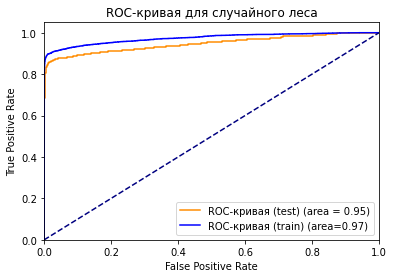

In [42]:
fpr_test, tpr_test, treshold_test = roc_curve(y_test, y_probs_test)
fpr_train, tpr_train, treshold_train = roc_curve(y_train, y_probs_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)
plt.plot(fpr_test, tpr_test, color='darkorange',
         label='ROC-кривая (test) (area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='blue', label='ROC-кривая (train) (area=%0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для случайного леса')
plt.legend(loc="lower right")
plt.show()

In [47]:
ece_score(y_test, y_probs)

0.19888236558652922

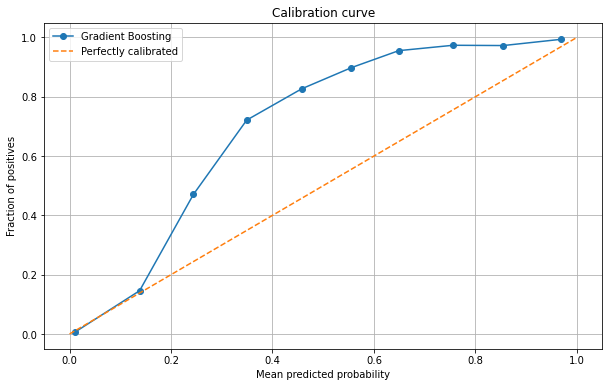

In [48]:
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Gradient Boosting')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [49]:
isotonic_clf = CalibratedClassifierCV(catboost_model, cv=2, method="isotonic")
isotonic_clf.fit(X_test, y_test)
prob_pos_isotonic = isotonic_clf.predict_proba(X_test)[:, 1]

Learning rate set to 0.029701
0:	learn: 0.6514724	total: 20.2ms	remaining: 20.1s
1:	learn: 0.6140807	total: 43.2ms	remaining: 21.6s
2:	learn: 0.5741836	total: 71.5ms	remaining: 23.8s
3:	learn: 0.5392821	total: 98.8ms	remaining: 24.6s
4:	learn: 0.5081318	total: 120ms	remaining: 24s
5:	learn: 0.4762933	total: 149ms	remaining: 24.6s
6:	learn: 0.4472207	total: 175ms	remaining: 24.8s
7:	learn: 0.4219360	total: 199ms	remaining: 24.6s
8:	learn: 0.4023210	total: 225ms	remaining: 24.8s
9:	learn: 0.3789826	total: 254ms	remaining: 25.1s
10:	learn: 0.3600772	total: 279ms	remaining: 25.1s
11:	learn: 0.3435429	total: 305ms	remaining: 25.1s
12:	learn: 0.3275551	total: 330ms	remaining: 25.1s
13:	learn: 0.3155381	total: 347ms	remaining: 24.4s
14:	learn: 0.3010773	total: 376ms	remaining: 24.7s
15:	learn: 0.2885721	total: 405ms	remaining: 24.9s
16:	learn: 0.2756570	total: 437ms	remaining: 25.3s
17:	learn: 0.2642190	total: 468ms	remaining: 25.5s
18:	learn: 0.2528122	total: 495ms	remaining: 25.6s
19:	learn

163:	learn: 0.0708747	total: 5.12s	remaining: 26.1s
164:	learn: 0.0707107	total: 5.15s	remaining: 26.1s
165:	learn: 0.0704339	total: 5.18s	remaining: 26.1s
166:	learn: 0.0702414	total: 5.22s	remaining: 26s
167:	learn: 0.0700672	total: 5.25s	remaining: 26s
168:	learn: 0.0697817	total: 5.28s	remaining: 26s
169:	learn: 0.0695677	total: 5.32s	remaining: 26s
170:	learn: 0.0693905	total: 5.35s	remaining: 25.9s
171:	learn: 0.0691159	total: 5.38s	remaining: 25.9s
172:	learn: 0.0688133	total: 5.42s	remaining: 25.9s
173:	learn: 0.0686497	total: 5.45s	remaining: 25.9s
174:	learn: 0.0684759	total: 5.48s	remaining: 25.8s
175:	learn: 0.0681978	total: 5.51s	remaining: 25.8s
176:	learn: 0.0678993	total: 5.55s	remaining: 25.8s
177:	learn: 0.0676944	total: 5.58s	remaining: 25.8s
178:	learn: 0.0675099	total: 5.61s	remaining: 25.7s
179:	learn: 0.0672334	total: 5.64s	remaining: 25.7s
180:	learn: 0.0669674	total: 5.67s	remaining: 25.7s
181:	learn: 0.0667936	total: 5.7s	remaining: 25.6s
182:	learn: 0.0666539

326:	learn: 0.0464787	total: 10.1s	remaining: 20.7s
327:	learn: 0.0463655	total: 10.1s	remaining: 20.7s
328:	learn: 0.0463241	total: 10.1s	remaining: 20.7s
329:	learn: 0.0462733	total: 10.2s	remaining: 20.6s
330:	learn: 0.0462306	total: 10.2s	remaining: 20.6s
331:	learn: 0.0461801	total: 10.2s	remaining: 20.6s
332:	learn: 0.0460961	total: 10.3s	remaining: 20.5s
333:	learn: 0.0460290	total: 10.3s	remaining: 20.5s
334:	learn: 0.0459345	total: 10.3s	remaining: 20.5s
335:	learn: 0.0458489	total: 10.3s	remaining: 20.4s
336:	learn: 0.0457641	total: 10.4s	remaining: 20.4s
337:	learn: 0.0456336	total: 10.4s	remaining: 20.4s
338:	learn: 0.0455115	total: 10.4s	remaining: 20.3s
339:	learn: 0.0454557	total: 10.5s	remaining: 20.3s
340:	learn: 0.0454061	total: 10.5s	remaining: 20.3s
341:	learn: 0.0453152	total: 10.5s	remaining: 20.2s
342:	learn: 0.0452481	total: 10.5s	remaining: 20.2s
343:	learn: 0.0450864	total: 10.6s	remaining: 20.1s
344:	learn: 0.0450023	total: 10.6s	remaining: 20.1s
345:	learn: 

485:	learn: 0.0346065	total: 14.5s	remaining: 15.3s
486:	learn: 0.0345225	total: 14.5s	remaining: 15.3s
487:	learn: 0.0344680	total: 14.5s	remaining: 15.2s
488:	learn: 0.0343836	total: 14.5s	remaining: 15.2s
489:	learn: 0.0343456	total: 14.6s	remaining: 15.2s
490:	learn: 0.0342390	total: 14.6s	remaining: 15.1s
491:	learn: 0.0341961	total: 14.6s	remaining: 15.1s
492:	learn: 0.0341065	total: 14.7s	remaining: 15.1s
493:	learn: 0.0340205	total: 14.7s	remaining: 15s
494:	learn: 0.0339549	total: 14.7s	remaining: 15s
495:	learn: 0.0339040	total: 14.7s	remaining: 15s
496:	learn: 0.0338475	total: 14.8s	remaining: 14.9s
497:	learn: 0.0337945	total: 14.8s	remaining: 14.9s
498:	learn: 0.0337673	total: 14.8s	remaining: 14.9s
499:	learn: 0.0337513	total: 14.8s	remaining: 14.8s
500:	learn: 0.0337256	total: 14.9s	remaining: 14.8s
501:	learn: 0.0336564	total: 14.9s	remaining: 14.8s
502:	learn: 0.0336165	total: 14.9s	remaining: 14.7s
503:	learn: 0.0335254	total: 14.9s	remaining: 14.7s
504:	learn: 0.0334

645:	learn: 0.0264960	total: 18.8s	remaining: 10.3s
646:	learn: 0.0264707	total: 18.8s	remaining: 10.3s
647:	learn: 0.0264409	total: 18.9s	remaining: 10.2s
648:	learn: 0.0264150	total: 18.9s	remaining: 10.2s
649:	learn: 0.0263950	total: 18.9s	remaining: 10.2s
650:	learn: 0.0263526	total: 18.9s	remaining: 10.2s
651:	learn: 0.0262986	total: 19s	remaining: 10.1s
652:	learn: 0.0262838	total: 19s	remaining: 10.1s
653:	learn: 0.0262540	total: 19s	remaining: 10.1s
654:	learn: 0.0261984	total: 19.1s	remaining: 10s
655:	learn: 0.0261651	total: 19.1s	remaining: 10s
656:	learn: 0.0261193	total: 19.1s	remaining: 9.98s
657:	learn: 0.0260628	total: 19.1s	remaining: 9.95s
658:	learn: 0.0259998	total: 19.2s	remaining: 9.92s
659:	learn: 0.0259873	total: 19.2s	remaining: 9.89s
660:	learn: 0.0259476	total: 19.2s	remaining: 9.86s
661:	learn: 0.0259321	total: 19.2s	remaining: 9.83s
662:	learn: 0.0259098	total: 19.3s	remaining: 9.79s
663:	learn: 0.0258067	total: 19.3s	remaining: 9.77s
664:	learn: 0.0257829	

811:	learn: 0.0206535	total: 23.4s	remaining: 5.41s
812:	learn: 0.0206045	total: 23.4s	remaining: 5.38s
813:	learn: 0.0205755	total: 23.4s	remaining: 5.35s
814:	learn: 0.0205206	total: 23.4s	remaining: 5.32s
815:	learn: 0.0204933	total: 23.5s	remaining: 5.29s
816:	learn: 0.0204586	total: 23.5s	remaining: 5.26s
817:	learn: 0.0204189	total: 23.5s	remaining: 5.23s
818:	learn: 0.0203946	total: 23.5s	remaining: 5.2s
819:	learn: 0.0203783	total: 23.6s	remaining: 5.17s
820:	learn: 0.0203503	total: 23.6s	remaining: 5.15s
821:	learn: 0.0203382	total: 23.6s	remaining: 5.12s
822:	learn: 0.0202848	total: 23.7s	remaining: 5.09s
823:	learn: 0.0202741	total: 23.7s	remaining: 5.06s
824:	learn: 0.0202275	total: 23.7s	remaining: 5.03s
825:	learn: 0.0201696	total: 23.7s	remaining: 5s
826:	learn: 0.0201432	total: 23.8s	remaining: 4.97s
827:	learn: 0.0200972	total: 23.8s	remaining: 4.94s
828:	learn: 0.0200551	total: 23.8s	remaining: 4.91s
829:	learn: 0.0200445	total: 23.8s	remaining: 4.88s
830:	learn: 0.01

970:	learn: 0.0162818	total: 27.7s	remaining: 827ms
971:	learn: 0.0162663	total: 27.7s	remaining: 799ms
972:	learn: 0.0162482	total: 27.8s	remaining: 770ms
973:	learn: 0.0162262	total: 27.8s	remaining: 741ms
974:	learn: 0.0162205	total: 27.8s	remaining: 713ms
975:	learn: 0.0162161	total: 27.8s	remaining: 684ms
976:	learn: 0.0161979	total: 27.9s	remaining: 656ms
977:	learn: 0.0161774	total: 27.9s	remaining: 627ms
978:	learn: 0.0161716	total: 27.9s	remaining: 599ms
979:	learn: 0.0161460	total: 27.9s	remaining: 570ms
980:	learn: 0.0161409	total: 28s	remaining: 542ms
981:	learn: 0.0160823	total: 28s	remaining: 513ms
982:	learn: 0.0160420	total: 28s	remaining: 485ms
983:	learn: 0.0159820	total: 28s	remaining: 456ms
984:	learn: 0.0159380	total: 28.1s	remaining: 428ms
985:	learn: 0.0159180	total: 28.1s	remaining: 399ms
986:	learn: 0.0159054	total: 28.1s	remaining: 371ms
987:	learn: 0.0158869	total: 28.2s	remaining: 342ms
988:	learn: 0.0158744	total: 28.2s	remaining: 313ms
989:	learn: 0.015823

137:	learn: 0.0792384	total: 3.77s	remaining: 23.5s
138:	learn: 0.0788270	total: 3.79s	remaining: 23.5s
139:	learn: 0.0787600	total: 3.82s	remaining: 23.5s
140:	learn: 0.0783869	total: 3.85s	remaining: 23.4s
141:	learn: 0.0781047	total: 3.87s	remaining: 23.4s
142:	learn: 0.0777848	total: 3.9s	remaining: 23.4s
143:	learn: 0.0775752	total: 3.93s	remaining: 23.3s
144:	learn: 0.0771946	total: 3.96s	remaining: 23.3s
145:	learn: 0.0769963	total: 3.98s	remaining: 23.3s
146:	learn: 0.0767002	total: 4.01s	remaining: 23.3s
147:	learn: 0.0764703	total: 4.04s	remaining: 23.2s
148:	learn: 0.0761927	total: 4.07s	remaining: 23.2s
149:	learn: 0.0758349	total: 4.09s	remaining: 23.2s
150:	learn: 0.0756144	total: 4.12s	remaining: 23.2s
151:	learn: 0.0753012	total: 4.15s	remaining: 23.1s
152:	learn: 0.0749488	total: 4.18s	remaining: 23.1s
153:	learn: 0.0745904	total: 4.2s	remaining: 23.1s
154:	learn: 0.0743651	total: 4.23s	remaining: 23.1s
155:	learn: 0.0742613	total: 4.26s	remaining: 23s
156:	learn: 0.07

297:	learn: 0.0497405	total: 8.18s	remaining: 19.3s
298:	learn: 0.0496615	total: 8.21s	remaining: 19.2s
299:	learn: 0.0495242	total: 8.23s	remaining: 19.2s
300:	learn: 0.0493659	total: 8.26s	remaining: 19.2s
301:	learn: 0.0493290	total: 8.29s	remaining: 19.2s
302:	learn: 0.0492495	total: 8.31s	remaining: 19.1s
303:	learn: 0.0490784	total: 8.34s	remaining: 19.1s
304:	learn: 0.0490042	total: 8.37s	remaining: 19.1s
305:	learn: 0.0489288	total: 8.39s	remaining: 19s
306:	learn: 0.0488170	total: 8.42s	remaining: 19s
307:	learn: 0.0487867	total: 8.45s	remaining: 19s
308:	learn: 0.0486836	total: 8.47s	remaining: 19s
309:	learn: 0.0486306	total: 8.5s	remaining: 18.9s
310:	learn: 0.0485115	total: 8.53s	remaining: 18.9s
311:	learn: 0.0484241	total: 8.55s	remaining: 18.9s
312:	learn: 0.0483389	total: 8.58s	remaining: 18.8s
313:	learn: 0.0481663	total: 8.61s	remaining: 18.8s
314:	learn: 0.0480776	total: 8.64s	remaining: 18.8s
315:	learn: 0.0479883	total: 8.67s	remaining: 18.8s
316:	learn: 0.0479222

456:	learn: 0.0352518	total: 12.6s	remaining: 14.9s
457:	learn: 0.0351899	total: 12.6s	remaining: 14.9s
458:	learn: 0.0351583	total: 12.6s	remaining: 14.9s
459:	learn: 0.0351257	total: 12.6s	remaining: 14.8s
460:	learn: 0.0350630	total: 12.7s	remaining: 14.8s
461:	learn: 0.0349993	total: 12.7s	remaining: 14.8s
462:	learn: 0.0349472	total: 12.7s	remaining: 14.7s
463:	learn: 0.0348307	total: 12.7s	remaining: 14.7s
464:	learn: 0.0347536	total: 12.8s	remaining: 14.7s
465:	learn: 0.0346730	total: 12.8s	remaining: 14.7s
466:	learn: 0.0345795	total: 12.8s	remaining: 14.6s
467:	learn: 0.0345216	total: 12.9s	remaining: 14.6s
468:	learn: 0.0344820	total: 12.9s	remaining: 14.6s
469:	learn: 0.0344298	total: 12.9s	remaining: 14.6s
470:	learn: 0.0343709	total: 12.9s	remaining: 14.5s
471:	learn: 0.0343178	total: 13s	remaining: 14.5s
472:	learn: 0.0342857	total: 13s	remaining: 14.5s
473:	learn: 0.0342285	total: 13s	remaining: 14.4s
474:	learn: 0.0341620	total: 13s	remaining: 14.4s
475:	learn: 0.034100

622:	learn: 0.0258182	total: 17.1s	remaining: 10.4s
623:	learn: 0.0257637	total: 17.1s	remaining: 10.3s
624:	learn: 0.0257252	total: 17.2s	remaining: 10.3s
625:	learn: 0.0256515	total: 17.2s	remaining: 10.3s
626:	learn: 0.0255870	total: 17.2s	remaining: 10.2s
627:	learn: 0.0255401	total: 17.3s	remaining: 10.2s
628:	learn: 0.0254713	total: 17.3s	remaining: 10.2s
629:	learn: 0.0254363	total: 17.3s	remaining: 10.2s
630:	learn: 0.0253580	total: 17.3s	remaining: 10.1s
631:	learn: 0.0252625	total: 17.4s	remaining: 10.1s
632:	learn: 0.0252350	total: 17.4s	remaining: 10.1s
633:	learn: 0.0251895	total: 17.4s	remaining: 10.1s
634:	learn: 0.0251138	total: 17.4s	remaining: 10s
635:	learn: 0.0250766	total: 17.5s	remaining: 10s
636:	learn: 0.0250322	total: 17.5s	remaining: 9.97s
637:	learn: 0.0249686	total: 17.5s	remaining: 9.94s
638:	learn: 0.0249405	total: 17.6s	remaining: 9.92s
639:	learn: 0.0248991	total: 17.6s	remaining: 9.89s
640:	learn: 0.0248136	total: 17.6s	remaining: 9.87s
641:	learn: 0.02

781:	learn: 0.0193058	total: 21.5s	remaining: 5.99s
782:	learn: 0.0192873	total: 21.5s	remaining: 5.96s
783:	learn: 0.0192695	total: 21.5s	remaining: 5.93s
784:	learn: 0.0192445	total: 21.6s	remaining: 5.9s
785:	learn: 0.0192255	total: 21.6s	remaining: 5.88s
786:	learn: 0.0191803	total: 21.6s	remaining: 5.85s
787:	learn: 0.0191533	total: 21.6s	remaining: 5.82s
788:	learn: 0.0191193	total: 21.7s	remaining: 5.79s
789:	learn: 0.0190970	total: 21.7s	remaining: 5.76s
790:	learn: 0.0190670	total: 21.7s	remaining: 5.74s
791:	learn: 0.0190461	total: 21.7s	remaining: 5.71s
792:	learn: 0.0190325	total: 21.8s	remaining: 5.68s
793:	learn: 0.0190007	total: 21.8s	remaining: 5.65s
794:	learn: 0.0189784	total: 21.8s	remaining: 5.63s
795:	learn: 0.0189514	total: 21.8s	remaining: 5.6s
796:	learn: 0.0189262	total: 21.9s	remaining: 5.57s
797:	learn: 0.0188968	total: 21.9s	remaining: 5.54s
798:	learn: 0.0188578	total: 21.9s	remaining: 5.52s
799:	learn: 0.0188451	total: 22s	remaining: 5.49s
800:	learn: 0.01

941:	learn: 0.0150951	total: 25.8s	remaining: 1.59s
942:	learn: 0.0150670	total: 25.8s	remaining: 1.56s
943:	learn: 0.0150258	total: 25.9s	remaining: 1.53s
944:	learn: 0.0150213	total: 25.9s	remaining: 1.51s
945:	learn: 0.0150097	total: 25.9s	remaining: 1.48s
946:	learn: 0.0149889	total: 25.9s	remaining: 1.45s
947:	learn: 0.0149747	total: 26s	remaining: 1.42s
948:	learn: 0.0149513	total: 26s	remaining: 1.4s
949:	learn: 0.0149375	total: 26s	remaining: 1.37s
950:	learn: 0.0149140	total: 26s	remaining: 1.34s
951:	learn: 0.0148885	total: 26.1s	remaining: 1.31s
952:	learn: 0.0148596	total: 26.1s	remaining: 1.29s
953:	learn: 0.0148424	total: 26.1s	remaining: 1.26s
954:	learn: 0.0148107	total: 26.2s	remaining: 1.23s
955:	learn: 0.0148003	total: 26.2s	remaining: 1.21s
956:	learn: 0.0147658	total: 26.2s	remaining: 1.18s
957:	learn: 0.0147585	total: 26.3s	remaining: 1.15s
958:	learn: 0.0147420	total: 26.3s	remaining: 1.12s
959:	learn: 0.0147231	total: 26.3s	remaining: 1.09s
960:	learn: 0.0147177

In [50]:
ece_score(y_test, prob_pos_isotonic)

0.17507932029776568

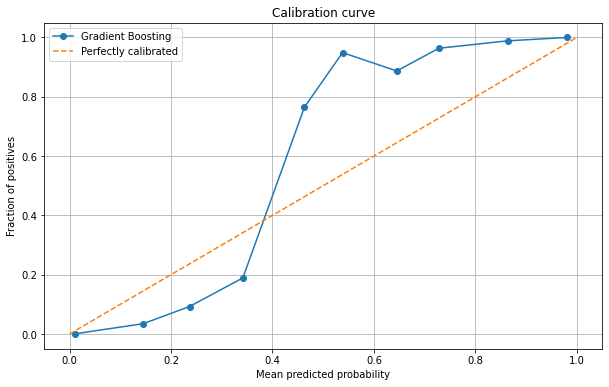

In [51]:
prob_true, prob_pred = calibration_curve(y_test, prob_pos_isotonic, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Gradient Boosting')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

Лучше всего откалибрована модель логистической регрессии => используем её результаты.

In [165]:
result = {'client_id': range(n_items := test_df.shape[0]),
          'product': ['credit card'] * n_items,
          'channel': ['sms'] * n_items,
          'score': list(prob_pos_isotonic)}

result_df = pd.DataFrame(result)
result_df.to_csv('credit_card_sms_result.csv')

# Модель для кредитов (звонки)

In [43]:
train_df = pd.read_csv('marketing_optimization_data/credit_call_train.csv')
test_df = pd.read_csv('marketing_optimization_data/credit_call_oot.csv')

In [44]:
X_train, y_train = train_df.drop(['target'], axis=1), train_df['target']
X_test, y_test = test_df.drop(['target'], axis=1), test_df['target']

In [45]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
print(classification_report(y_test, lr_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18909
           1       0.85      0.50      0.63      1091

    accuracy                           0.97     20000
   macro avg       0.91      0.75      0.81     20000
weighted avg       0.97      0.97      0.96     20000



In [46]:
roc_auc_score(y_test, y_probs_test := lr_model.predict_proba(X_test)[:, 1])

0.9143759059442351

In [47]:
roc_auc_score(y_train, y_probs_train := lr_model.predict_proba(X_train)[:, 1])

0.917536940444349

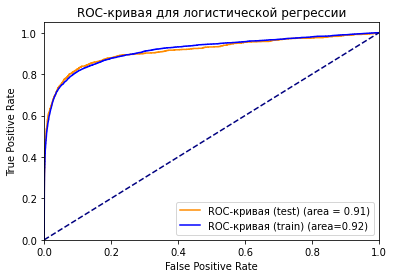

In [48]:
fpr_test, tpr_test, treshold_test = roc_curve(y_test, y_probs_test)
fpr_train, tpr_train, treshold_train = roc_curve(y_train, y_probs_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)
plt.plot(fpr_test, tpr_test, color='darkorange',
         label='ROC-кривая (test) (area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='blue', label='ROC-кривая (train) (area=%0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для логистической регрессии')
plt.legend(loc="lower right")
plt.show()

In [112]:
ece_score(y_test, y_probs)

0.0492302885661114

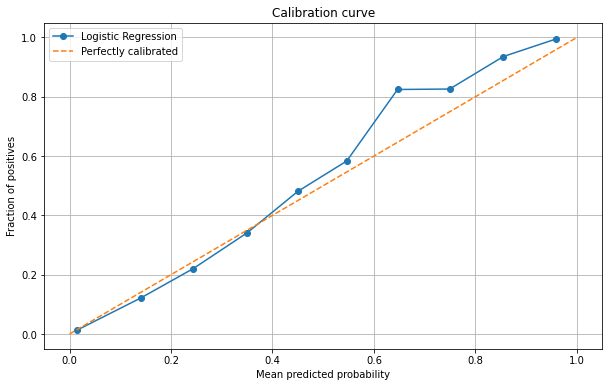

In [113]:
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [116]:
isotonic_clf = CalibratedClassifierCV(lr_model, cv=2, method="isotonic")
isotonic_clf.fit(X_test, y_test)
prob_pos_isotonic = isotonic_clf.predict_proba(X_test)[:, 1]

In [117]:
ece_score(y_test, prob_pos_isotonic)

0.028839138667065594

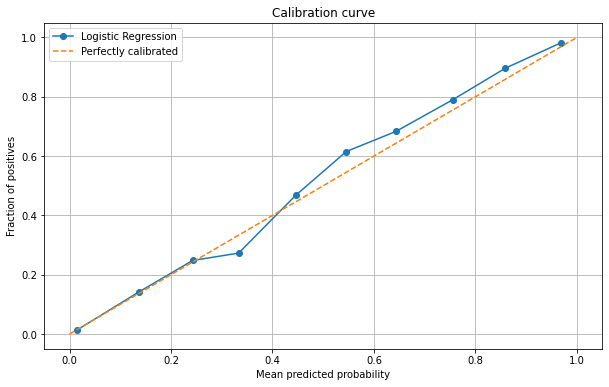

In [107]:
prob_true, prob_pred = calibration_curve(y_test, prob_pos_isotonic, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [49]:
rf_model = RandomForestClassifier(n_jobs=-1)
rf_model.fit(X_train, y_train)
print(classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18909
           1       1.00      0.19      0.32      1091

    accuracy                           0.96     20000
   macro avg       0.98      0.59      0.65     20000
weighted avg       0.96      0.96      0.94     20000



In [50]:
roc_auc_score(y_test, y_probs_test := rf_model.predict_proba(X_test)[:, 1])

0.9423789049186758

In [51]:
roc_auc_score(y_train, y_probs_train := rf_model.predict_proba(X_train)[:, 1])

1.0

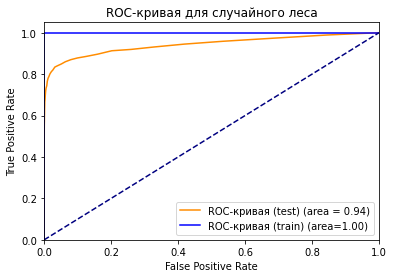

In [52]:
fpr_test, tpr_test, treshold_test = roc_curve(y_test, y_probs_test)
fpr_train, tpr_train, treshold_train = roc_curve(y_train, y_probs_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)
plt.plot(fpr_test, tpr_test, color='darkorange',
         label='ROC-кривая (test) (area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='blue', label='ROC-кривая (train) (area=%0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для случайного леса')
plt.legend(loc="lower right")
plt.show()

In [120]:
ece_score(y_test, y_probs)

0.27520130037166096

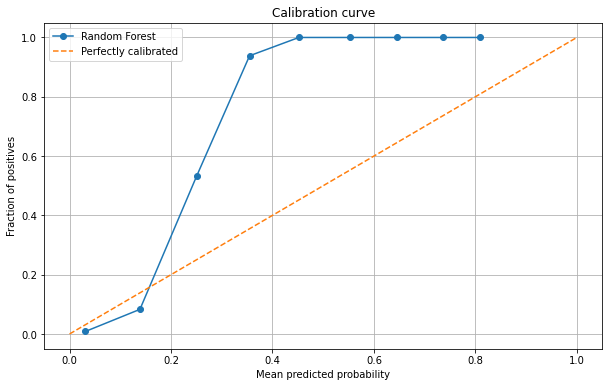

In [64]:
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [127]:
isotonic_clf = CalibratedClassifierCV(rf_model, cv=2, method="isotonic")
isotonic_clf.fit(X_test, y_test)
prob_pos_isotonic = isotonic_clf.predict_proba(X_test)[:, 1]

In [128]:
ece_score(y_test, prob_pos_isotonic)

0.23472580875567595

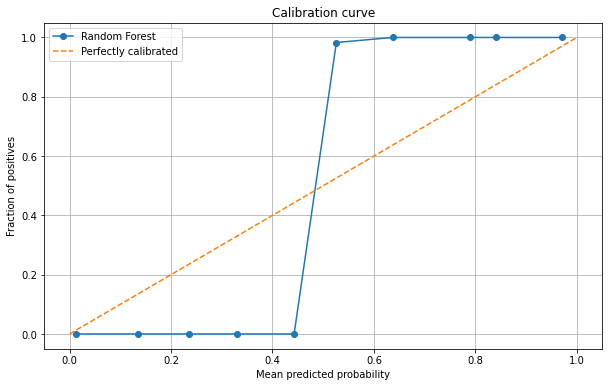

In [67]:
prob_true, prob_pred = calibration_curve(y_test, prob_pos_isotonic, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [53]:
catboost_model = CatBoostClassifier(task_type='GPU')
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)
catboost_model.fit(X_train, y_train, plot=True, use_best_model=False)
print(classification_report(y_test, catboost_model.predict(X_test)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.026491
0:	learn: 0.6540253	total: 10.5ms	remaining: 10.4s
1:	learn: 0.6182933	total: 17ms	remaining: 8.49s
2:	learn: 0.5862345	total: 23.3ms	remaining: 7.74s
3:	learn: 0.5563314	total: 30.2ms	remaining: 7.51s
4:	learn: 0.5278898	total: 36.5ms	remaining: 7.26s
5:	learn: 0.5008797	total: 42.8ms	remaining: 7.09s
6:	learn: 0.4764889	total: 48.9ms	remaining: 6.94s
7:	learn: 0.4548733	total: 54.8ms	remaining: 6.79s
8:	learn: 0.4342363	total: 61.2ms	remaining: 6.74s
9:	learn: 0.4153282	total: 67.3ms	remaining: 6.66s
10:	learn: 0.3980423	total: 73.3ms	remaining: 6.59s
11:	learn: 0.3813077	total: 79.4ms	remaining: 6.54s
12:	learn: 0.3662791	total: 86.2ms	remaining: 6.55s
13:	learn: 0.3517151	total: 93.7ms	remaining: 6.6s
14:	learn: 0.3392114	total: 101ms	remaining: 6.62s
15:	learn: 0.3280232	total: 107ms	remaining: 6.57s
16:	learn: 0.3169339	total: 113ms	remaining: 6.52s
17:	learn: 0.3072834	total: 119ms	remaining: 6.49s
18:	learn: 0.2969454	total: 125ms	remaining: 6.45s


186:	learn: 0.1034699	total: 1.24s	remaining: 5.37s
187:	learn: 0.1031746	total: 1.26s	remaining: 5.43s
188:	learn: 0.1029557	total: 1.26s	remaining: 5.43s
189:	learn: 0.1027624	total: 1.27s	remaining: 5.43s
190:	learn: 0.1024832	total: 1.28s	remaining: 5.44s
191:	learn: 0.1022718	total: 1.29s	remaining: 5.44s
192:	learn: 0.1020516	total: 1.3s	remaining: 5.43s
193:	learn: 0.1017832	total: 1.3s	remaining: 5.42s
194:	learn: 0.1015885	total: 1.31s	remaining: 5.43s
195:	learn: 0.1013675	total: 1.32s	remaining: 5.42s
196:	learn: 0.1012359	total: 1.33s	remaining: 5.41s
197:	learn: 0.1009355	total: 1.33s	remaining: 5.4s
198:	learn: 0.1007096	total: 1.34s	remaining: 5.4s
199:	learn: 0.1005099	total: 1.35s	remaining: 5.39s
200:	learn: 0.1002861	total: 1.35s	remaining: 5.38s
201:	learn: 0.1000743	total: 1.36s	remaining: 5.37s
202:	learn: 0.0997685	total: 1.37s	remaining: 5.37s
203:	learn: 0.0995840	total: 1.37s	remaining: 5.36s
204:	learn: 0.0993620	total: 1.38s	remaining: 5.36s
205:	learn: 0.09

368:	learn: 0.0747436	total: 2.49s	remaining: 4.26s
369:	learn: 0.0746204	total: 2.5s	remaining: 4.26s
370:	learn: 0.0745025	total: 2.51s	remaining: 4.25s
371:	learn: 0.0744131	total: 2.51s	remaining: 4.24s
372:	learn: 0.0742690	total: 2.52s	remaining: 4.24s
373:	learn: 0.0741887	total: 2.53s	remaining: 4.23s
374:	learn: 0.0740821	total: 2.53s	remaining: 4.22s
375:	learn: 0.0739915	total: 2.54s	remaining: 4.21s
376:	learn: 0.0739080	total: 2.55s	remaining: 4.21s
377:	learn: 0.0738244	total: 2.56s	remaining: 4.2s
378:	learn: 0.0737200	total: 2.56s	remaining: 4.2s
379:	learn: 0.0736357	total: 2.57s	remaining: 4.19s
380:	learn: 0.0735252	total: 2.58s	remaining: 4.18s
381:	learn: 0.0734224	total: 2.58s	remaining: 4.18s
382:	learn: 0.0733333	total: 2.59s	remaining: 4.17s
383:	learn: 0.0731740	total: 2.59s	remaining: 4.16s
384:	learn: 0.0730932	total: 2.6s	remaining: 4.16s
385:	learn: 0.0729874	total: 2.61s	remaining: 4.15s
386:	learn: 0.0728942	total: 2.61s	remaining: 4.14s
387:	learn: 0.07

535:	learn: 0.0611892	total: 3.74s	remaining: 3.24s
536:	learn: 0.0611436	total: 3.75s	remaining: 3.23s
537:	learn: 0.0610718	total: 3.76s	remaining: 3.23s
538:	learn: 0.0610052	total: 3.77s	remaining: 3.22s
539:	learn: 0.0609519	total: 3.77s	remaining: 3.22s
540:	learn: 0.0608842	total: 3.78s	remaining: 3.21s
541:	learn: 0.0608414	total: 3.79s	remaining: 3.2s
542:	learn: 0.0607813	total: 3.8s	remaining: 3.19s
543:	learn: 0.0607240	total: 3.81s	remaining: 3.19s
544:	learn: 0.0606738	total: 3.81s	remaining: 3.18s
545:	learn: 0.0606400	total: 3.82s	remaining: 3.18s
546:	learn: 0.0606131	total: 3.83s	remaining: 3.17s
547:	learn: 0.0605497	total: 3.83s	remaining: 3.16s
548:	learn: 0.0605078	total: 3.84s	remaining: 3.15s
549:	learn: 0.0604745	total: 3.85s	remaining: 3.15s
550:	learn: 0.0603977	total: 3.85s	remaining: 3.14s
551:	learn: 0.0603459	total: 3.86s	remaining: 3.13s
552:	learn: 0.0602647	total: 3.87s	remaining: 3.13s
553:	learn: 0.0601903	total: 3.88s	remaining: 3.12s
554:	learn: 0.

715:	learn: 0.0535327	total: 5s	remaining: 1.98s
716:	learn: 0.0534725	total: 5s	remaining: 1.98s
717:	learn: 0.0534578	total: 5.01s	remaining: 1.97s
718:	learn: 0.0534378	total: 5.02s	remaining: 1.96s
719:	learn: 0.0534058	total: 5.02s	remaining: 1.95s
720:	learn: 0.0533578	total: 5.03s	remaining: 1.95s
721:	learn: 0.0533431	total: 5.04s	remaining: 1.94s
722:	learn: 0.0533209	total: 5.04s	remaining: 1.93s
723:	learn: 0.0532885	total: 5.05s	remaining: 1.93s
724:	learn: 0.0532205	total: 5.06s	remaining: 1.92s
725:	learn: 0.0531714	total: 5.06s	remaining: 1.91s
726:	learn: 0.0531585	total: 5.07s	remaining: 1.9s
727:	learn: 0.0531123	total: 5.08s	remaining: 1.9s
728:	learn: 0.0530899	total: 5.08s	remaining: 1.89s
729:	learn: 0.0530585	total: 5.09s	remaining: 1.88s
730:	learn: 0.0530283	total: 5.1s	remaining: 1.88s
731:	learn: 0.0530021	total: 5.1s	remaining: 1.87s
732:	learn: 0.0529774	total: 5.11s	remaining: 1.86s
733:	learn: 0.0529687	total: 5.12s	remaining: 1.85s
734:	learn: 0.0529379	

894:	learn: 0.0488632	total: 6.25s	remaining: 733ms
895:	learn: 0.0488164	total: 6.26s	remaining: 726ms
896:	learn: 0.0488040	total: 6.26s	remaining: 719ms
897:	learn: 0.0487613	total: 6.27s	remaining: 712ms
898:	learn: 0.0487363	total: 6.28s	remaining: 705ms
899:	learn: 0.0487149	total: 6.28s	remaining: 698ms
900:	learn: 0.0487030	total: 6.29s	remaining: 691ms
901:	learn: 0.0486822	total: 6.3s	remaining: 684ms
902:	learn: 0.0486472	total: 6.3s	remaining: 677ms
903:	learn: 0.0486408	total: 6.31s	remaining: 670ms
904:	learn: 0.0486188	total: 6.32s	remaining: 663ms
905:	learn: 0.0485746	total: 6.33s	remaining: 656ms
906:	learn: 0.0485605	total: 6.33s	remaining: 649ms
907:	learn: 0.0485281	total: 6.34s	remaining: 642ms
908:	learn: 0.0485195	total: 6.35s	remaining: 636ms
909:	learn: 0.0484898	total: 6.36s	remaining: 629ms
910:	learn: 0.0484738	total: 6.36s	remaining: 622ms
911:	learn: 0.0484542	total: 6.37s	remaining: 615ms
912:	learn: 0.0484409	total: 6.38s	remaining: 608ms
913:	learn: 0.

In [54]:
roc_auc_score(y_test, y_probs_test := catboost_model.predict_proba(X_test)[:, 1])

0.9524149601843827

In [55]:
roc_auc_score(y_train, y_probs_train := catboost_model.predict_proba(X_train)[:, 1])

0.9771183209718521

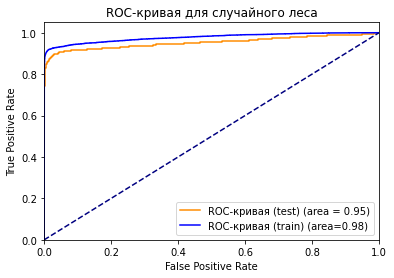

In [56]:
fpr_test, tpr_test, treshold_test = roc_curve(y_test, y_probs_test)
fpr_train, tpr_train, treshold_train = roc_curve(y_train, y_probs_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)
plt.plot(fpr_test, tpr_test, color='darkorange',
         label='ROC-кривая (test) (area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='blue', label='ROC-кривая (train) (area=%0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для случайного леса')
plt.legend(loc="lower right")
plt.show()

In [131]:
ece_score(y_test, y_probs)

0.195213305908567

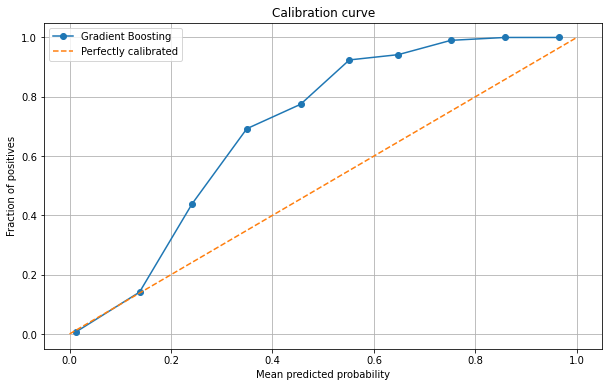

In [71]:
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Gradient Boosting')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [134]:
isotonic_clf = CalibratedClassifierCV(catboost_model, cv=2, method="isotonic")
isotonic_clf.fit(X_test, y_test)
prob_pos_isotonic = isotonic_clf.predict_proba(X_test)[:, 1]

Learning rate set to 0.029701
0:	learn: 0.6518024	total: 23.7ms	remaining: 23.7s
1:	learn: 0.6140983	total: 52.3ms	remaining: 26.1s
2:	learn: 0.5781848	total: 80.9ms	remaining: 26.9s
3:	learn: 0.5478017	total: 97.4ms	remaining: 24.3s
4:	learn: 0.5169804	total: 124ms	remaining: 24.7s
5:	learn: 0.4893130	total: 151ms	remaining: 25.1s
6:	learn: 0.4638917	total: 178ms	remaining: 25.3s
7:	learn: 0.4399443	total: 206ms	remaining: 25.6s
8:	learn: 0.4196358	total: 232ms	remaining: 25.6s
9:	learn: 0.4000013	total: 260ms	remaining: 25.7s
10:	learn: 0.3814780	total: 287ms	remaining: 25.8s
11:	learn: 0.3661577	total: 314ms	remaining: 25.9s
12:	learn: 0.3500918	total: 341ms	remaining: 25.9s
13:	learn: 0.3374442	total: 369ms	remaining: 26s
14:	learn: 0.3240902	total: 396ms	remaining: 26s
15:	learn: 0.3131567	total: 423ms	remaining: 26s
16:	learn: 0.3007647	total: 451ms	remaining: 26.1s
17:	learn: 0.2907494	total: 479ms	remaining: 26.2s
18:	learn: 0.2813008	total: 508ms	remaining: 26.3s
19:	learn: 0.

166:	learn: 0.0904078	total: 4.67s	remaining: 23.3s
167:	learn: 0.0900728	total: 4.7s	remaining: 23.3s
168:	learn: 0.0896392	total: 4.73s	remaining: 23.3s
169:	learn: 0.0892999	total: 4.76s	remaining: 23.2s
170:	learn: 0.0888723	total: 4.79s	remaining: 23.2s
171:	learn: 0.0885653	total: 4.81s	remaining: 23.2s
172:	learn: 0.0883359	total: 4.84s	remaining: 23.1s
173:	learn: 0.0880131	total: 4.87s	remaining: 23.1s
174:	learn: 0.0877169	total: 4.9s	remaining: 23.1s
175:	learn: 0.0874536	total: 4.92s	remaining: 23.1s
176:	learn: 0.0871176	total: 4.95s	remaining: 23s
177:	learn: 0.0867897	total: 4.98s	remaining: 23s
178:	learn: 0.0865320	total: 5.01s	remaining: 23s
179:	learn: 0.0863038	total: 5.04s	remaining: 22.9s
180:	learn: 0.0860010	total: 5.06s	remaining: 22.9s
181:	learn: 0.0856198	total: 5.09s	remaining: 22.9s
182:	learn: 0.0853599	total: 5.12s	remaining: 22.9s
183:	learn: 0.0849396	total: 5.15s	remaining: 22.8s
184:	learn: 0.0845888	total: 5.17s	remaining: 22.8s
185:	learn: 0.084429

330:	learn: 0.0565218	total: 9.35s	remaining: 18.9s
331:	learn: 0.0563701	total: 9.37s	remaining: 18.9s
332:	learn: 0.0562697	total: 9.4s	remaining: 18.8s
333:	learn: 0.0561656	total: 9.43s	remaining: 18.8s
334:	learn: 0.0560997	total: 9.45s	remaining: 18.8s
335:	learn: 0.0559640	total: 9.48s	remaining: 18.7s
336:	learn: 0.0558986	total: 9.51s	remaining: 18.7s
337:	learn: 0.0557977	total: 9.53s	remaining: 18.7s
338:	learn: 0.0557213	total: 9.56s	remaining: 18.6s
339:	learn: 0.0556210	total: 9.59s	remaining: 18.6s
340:	learn: 0.0555232	total: 9.61s	remaining: 18.6s
341:	learn: 0.0554109	total: 9.64s	remaining: 18.5s
342:	learn: 0.0552126	total: 9.67s	remaining: 18.5s
343:	learn: 0.0551006	total: 9.7s	remaining: 18.5s
344:	learn: 0.0548842	total: 9.72s	remaining: 18.5s
345:	learn: 0.0547919	total: 9.75s	remaining: 18.4s
346:	learn: 0.0546791	total: 9.78s	remaining: 18.4s
347:	learn: 0.0546042	total: 9.8s	remaining: 18.4s
348:	learn: 0.0545138	total: 9.83s	remaining: 18.3s
349:	learn: 0.0

489:	learn: 0.0415795	total: 13.8s	remaining: 14.3s
490:	learn: 0.0415033	total: 13.8s	remaining: 14.3s
491:	learn: 0.0414374	total: 13.8s	remaining: 14.3s
492:	learn: 0.0413564	total: 13.8s	remaining: 14.2s
493:	learn: 0.0412609	total: 13.9s	remaining: 14.2s
494:	learn: 0.0411943	total: 13.9s	remaining: 14.2s
495:	learn: 0.0411569	total: 13.9s	remaining: 14.1s
496:	learn: 0.0410826	total: 13.9s	remaining: 14.1s
497:	learn: 0.0410528	total: 14s	remaining: 14.1s
498:	learn: 0.0410055	total: 14s	remaining: 14.1s
499:	learn: 0.0409322	total: 14s	remaining: 14s
500:	learn: 0.0408971	total: 14s	remaining: 14s
501:	learn: 0.0408268	total: 14.1s	remaining: 14s
502:	learn: 0.0407722	total: 14.1s	remaining: 13.9s
503:	learn: 0.0407220	total: 14.1s	remaining: 13.9s
504:	learn: 0.0406147	total: 14.2s	remaining: 13.9s
505:	learn: 0.0405512	total: 14.2s	remaining: 13.8s
506:	learn: 0.0404348	total: 14.2s	remaining: 13.8s
507:	learn: 0.0403182	total: 14.2s	remaining: 13.8s
508:	learn: 0.0402481	tota

655:	learn: 0.0322030	total: 18.3s	remaining: 9.59s
656:	learn: 0.0321603	total: 18.3s	remaining: 9.56s
657:	learn: 0.0321406	total: 18.3s	remaining: 9.53s
658:	learn: 0.0320699	total: 18.4s	remaining: 9.5s
659:	learn: 0.0320215	total: 18.4s	remaining: 9.47s
660:	learn: 0.0319297	total: 18.4s	remaining: 9.45s
661:	learn: 0.0318590	total: 18.4s	remaining: 9.42s
662:	learn: 0.0317535	total: 18.5s	remaining: 9.39s
663:	learn: 0.0316679	total: 18.5s	remaining: 9.36s
664:	learn: 0.0315933	total: 18.5s	remaining: 9.33s
665:	learn: 0.0315025	total: 18.6s	remaining: 9.31s
666:	learn: 0.0314819	total: 18.6s	remaining: 9.28s
667:	learn: 0.0314069	total: 18.6s	remaining: 9.25s
668:	learn: 0.0313418	total: 18.6s	remaining: 9.22s
669:	learn: 0.0312520	total: 18.7s	remaining: 9.19s
670:	learn: 0.0311420	total: 18.7s	remaining: 9.16s
671:	learn: 0.0311322	total: 18.7s	remaining: 9.14s
672:	learn: 0.0310994	total: 18.7s	remaining: 9.11s
673:	learn: 0.0310866	total: 18.8s	remaining: 9.08s
674:	learn: 0

815:	learn: 0.0260313	total: 22.6s	remaining: 5.11s
816:	learn: 0.0259864	total: 22.7s	remaining: 5.08s
817:	learn: 0.0259562	total: 22.7s	remaining: 5.05s
818:	learn: 0.0258525	total: 22.7s	remaining: 5.02s
819:	learn: 0.0258339	total: 22.8s	remaining: 4.99s
820:	learn: 0.0258107	total: 22.8s	remaining: 4.97s
821:	learn: 0.0257604	total: 22.8s	remaining: 4.94s
822:	learn: 0.0257529	total: 22.8s	remaining: 4.91s
823:	learn: 0.0257163	total: 22.9s	remaining: 4.88s
824:	learn: 0.0256065	total: 22.9s	remaining: 4.85s
825:	learn: 0.0255605	total: 22.9s	remaining: 4.83s
826:	learn: 0.0255410	total: 22.9s	remaining: 4.8s
827:	learn: 0.0254999	total: 23s	remaining: 4.77s
828:	learn: 0.0254630	total: 23s	remaining: 4.74s
829:	learn: 0.0254104	total: 23s	remaining: 4.71s
830:	learn: 0.0253826	total: 23s	remaining: 4.69s
831:	learn: 0.0253671	total: 23.1s	remaining: 4.66s
832:	learn: 0.0253539	total: 23.1s	remaining: 4.63s
833:	learn: 0.0253383	total: 23.1s	remaining: 4.6s
834:	learn: 0.0253194	

974:	learn: 0.0211038	total: 27s	remaining: 693ms
975:	learn: 0.0210993	total: 27.1s	remaining: 665ms
976:	learn: 0.0210834	total: 27.1s	remaining: 638ms
977:	learn: 0.0210485	total: 27.1s	remaining: 610ms
978:	learn: 0.0210116	total: 27.1s	remaining: 582ms
979:	learn: 0.0210045	total: 27.2s	remaining: 554ms
980:	learn: 0.0209494	total: 27.2s	remaining: 527ms
981:	learn: 0.0209402	total: 27.2s	remaining: 499ms
982:	learn: 0.0209263	total: 27.2s	remaining: 471ms
983:	learn: 0.0209156	total: 27.3s	remaining: 444ms
984:	learn: 0.0208847	total: 27.3s	remaining: 416ms
985:	learn: 0.0208647	total: 27.3s	remaining: 388ms
986:	learn: 0.0208217	total: 27.4s	remaining: 360ms
987:	learn: 0.0208131	total: 27.4s	remaining: 333ms
988:	learn: 0.0207979	total: 27.4s	remaining: 305ms
989:	learn: 0.0207876	total: 27.4s	remaining: 277ms
990:	learn: 0.0207794	total: 27.5s	remaining: 249ms
991:	learn: 0.0207699	total: 27.5s	remaining: 222ms
992:	learn: 0.0207331	total: 27.5s	remaining: 194ms
993:	learn: 0.

138:	learn: 0.1089253	total: 3.94s	remaining: 24.4s
139:	learn: 0.1087320	total: 3.96s	remaining: 24.4s
140:	learn: 0.1082367	total: 3.99s	remaining: 24.3s
141:	learn: 0.1077442	total: 4.02s	remaining: 24.3s
142:	learn: 0.1075109	total: 4.04s	remaining: 24.2s
143:	learn: 0.1070954	total: 4.07s	remaining: 24.2s
144:	learn: 0.1067713	total: 4.1s	remaining: 24.2s
145:	learn: 0.1064517	total: 4.13s	remaining: 24.1s
146:	learn: 0.1060808	total: 4.15s	remaining: 24.1s
147:	learn: 0.1054029	total: 4.18s	remaining: 24.1s
148:	learn: 0.1051266	total: 4.21s	remaining: 24s
149:	learn: 0.1045027	total: 4.24s	remaining: 24s
150:	learn: 0.1040789	total: 4.26s	remaining: 24s
151:	learn: 0.1036843	total: 4.29s	remaining: 23.9s
152:	learn: 0.1032767	total: 4.32s	remaining: 23.9s
153:	learn: 0.1028530	total: 4.35s	remaining: 23.9s
154:	learn: 0.1024694	total: 4.37s	remaining: 23.8s
155:	learn: 0.1020701	total: 4.4s	remaining: 23.8s
156:	learn: 0.1018410	total: 4.43s	remaining: 23.8s
157:	learn: 0.101629

298:	learn: 0.0676323	total: 8.3s	remaining: 19.5s
299:	learn: 0.0674754	total: 8.33s	remaining: 19.4s
300:	learn: 0.0673006	total: 8.36s	remaining: 19.4s
301:	learn: 0.0671221	total: 8.38s	remaining: 19.4s
302:	learn: 0.0668339	total: 8.41s	remaining: 19.4s
303:	learn: 0.0666886	total: 8.44s	remaining: 19.3s
304:	learn: 0.0665669	total: 8.47s	remaining: 19.3s
305:	learn: 0.0664775	total: 8.49s	remaining: 19.3s
306:	learn: 0.0663563	total: 8.52s	remaining: 19.2s
307:	learn: 0.0660764	total: 8.55s	remaining: 19.2s
308:	learn: 0.0659039	total: 8.58s	remaining: 19.2s
309:	learn: 0.0656762	total: 8.61s	remaining: 19.2s
310:	learn: 0.0655026	total: 8.63s	remaining: 19.1s
311:	learn: 0.0653854	total: 8.66s	remaining: 19.1s
312:	learn: 0.0652599	total: 8.69s	remaining: 19.1s
313:	learn: 0.0650595	total: 8.71s	remaining: 19s
314:	learn: 0.0648258	total: 8.74s	remaining: 19s
315:	learn: 0.0646740	total: 8.78s	remaining: 19s
316:	learn: 0.0644694	total: 8.8s	remaining: 19s
317:	learn: 0.0643087	

457:	learn: 0.0476649	total: 12.7s	remaining: 15s
458:	learn: 0.0475966	total: 12.7s	remaining: 15s
459:	learn: 0.0475236	total: 12.7s	remaining: 14.9s
460:	learn: 0.0474144	total: 12.8s	remaining: 14.9s
461:	learn: 0.0472942	total: 12.8s	remaining: 14.9s
462:	learn: 0.0471976	total: 12.8s	remaining: 14.9s
463:	learn: 0.0470630	total: 12.8s	remaining: 14.8s
464:	learn: 0.0469704	total: 12.9s	remaining: 14.8s
465:	learn: 0.0468892	total: 12.9s	remaining: 14.8s
466:	learn: 0.0467962	total: 12.9s	remaining: 14.7s
467:	learn: 0.0467318	total: 12.9s	remaining: 14.7s
468:	learn: 0.0466558	total: 13s	remaining: 14.7s
469:	learn: 0.0466234	total: 13s	remaining: 14.7s
470:	learn: 0.0465226	total: 13s	remaining: 14.6s
471:	learn: 0.0464478	total: 13.1s	remaining: 14.6s
472:	learn: 0.0463466	total: 13.1s	remaining: 14.6s
473:	learn: 0.0462183	total: 13.1s	remaining: 14.6s
474:	learn: 0.0461409	total: 13.2s	remaining: 14.5s
475:	learn: 0.0460573	total: 13.2s	remaining: 14.5s
476:	learn: 0.0459816	

617:	learn: 0.0360685	total: 17.1s	remaining: 10.6s
618:	learn: 0.0360221	total: 17.1s	remaining: 10.5s
619:	learn: 0.0359781	total: 17.2s	remaining: 10.5s
620:	learn: 0.0359287	total: 17.2s	remaining: 10.5s
621:	learn: 0.0358498	total: 17.2s	remaining: 10.5s
622:	learn: 0.0358186	total: 17.2s	remaining: 10.4s
623:	learn: 0.0357503	total: 17.3s	remaining: 10.4s
624:	learn: 0.0356995	total: 17.3s	remaining: 10.4s
625:	learn: 0.0356155	total: 17.3s	remaining: 10.3s
626:	learn: 0.0355546	total: 17.3s	remaining: 10.3s
627:	learn: 0.0355080	total: 17.4s	remaining: 10.3s
628:	learn: 0.0354161	total: 17.4s	remaining: 10.3s
629:	learn: 0.0353674	total: 17.4s	remaining: 10.2s
630:	learn: 0.0353358	total: 17.5s	remaining: 10.2s
631:	learn: 0.0352572	total: 17.5s	remaining: 10.2s
632:	learn: 0.0352020	total: 17.5s	remaining: 10.1s
633:	learn: 0.0351050	total: 17.5s	remaining: 10.1s
634:	learn: 0.0350413	total: 17.6s	remaining: 10.1s
635:	learn: 0.0349790	total: 17.6s	remaining: 10.1s
636:	learn: 

776:	learn: 0.0277846	total: 21.4s	remaining: 6.15s
777:	learn: 0.0277711	total: 21.5s	remaining: 6.12s
778:	learn: 0.0277314	total: 21.5s	remaining: 6.1s
779:	learn: 0.0276979	total: 21.5s	remaining: 6.07s
780:	learn: 0.0276493	total: 21.5s	remaining: 6.04s
781:	learn: 0.0275945	total: 21.6s	remaining: 6.01s
782:	learn: 0.0275520	total: 21.6s	remaining: 5.98s
783:	learn: 0.0275247	total: 21.6s	remaining: 5.96s
784:	learn: 0.0275061	total: 21.6s	remaining: 5.93s
785:	learn: 0.0274895	total: 21.7s	remaining: 5.9s
786:	learn: 0.0274811	total: 21.7s	remaining: 5.87s
787:	learn: 0.0274418	total: 21.7s	remaining: 5.85s
788:	learn: 0.0274133	total: 21.8s	remaining: 5.82s
789:	learn: 0.0273353	total: 21.8s	remaining: 5.79s
790:	learn: 0.0273246	total: 21.8s	remaining: 5.76s
791:	learn: 0.0272918	total: 21.8s	remaining: 5.74s
792:	learn: 0.0272693	total: 21.9s	remaining: 5.71s
793:	learn: 0.0272246	total: 21.9s	remaining: 5.68s
794:	learn: 0.0271805	total: 21.9s	remaining: 5.65s
795:	learn: 0.

936:	learn: 0.0218905	total: 25.8s	remaining: 1.73s
937:	learn: 0.0218584	total: 25.8s	remaining: 1.71s
938:	learn: 0.0218321	total: 25.8s	remaining: 1.68s
939:	learn: 0.0218138	total: 25.9s	remaining: 1.65s
940:	learn: 0.0218107	total: 25.9s	remaining: 1.62s
941:	learn: 0.0217829	total: 25.9s	remaining: 1.6s
942:	learn: 0.0217616	total: 25.9s	remaining: 1.57s
943:	learn: 0.0217311	total: 26s	remaining: 1.54s
944:	learn: 0.0217161	total: 26s	remaining: 1.51s
945:	learn: 0.0216828	total: 26s	remaining: 1.49s
946:	learn: 0.0216390	total: 26.1s	remaining: 1.46s
947:	learn: 0.0216318	total: 26.1s	remaining: 1.43s
948:	learn: 0.0216075	total: 26.1s	remaining: 1.4s
949:	learn: 0.0215684	total: 26.1s	remaining: 1.38s
950:	learn: 0.0215083	total: 26.2s	remaining: 1.35s
951:	learn: 0.0214813	total: 26.2s	remaining: 1.32s
952:	learn: 0.0214372	total: 26.2s	remaining: 1.29s
953:	learn: 0.0214179	total: 26.2s	remaining: 1.26s
954:	learn: 0.0213862	total: 26.3s	remaining: 1.24s
955:	learn: 0.021351

In [135]:
ece_score(y_test, prob_pos_isotonic)

0.15185249598223666

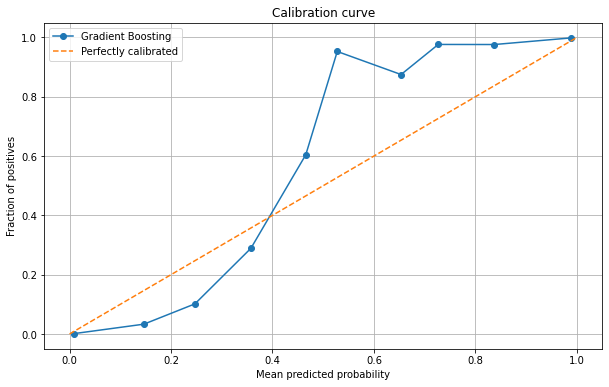

In [74]:
prob_true, prob_pred = calibration_curve(y_test, prob_pos_isotonic, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Gradient Boosting')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

Лучше всего откалибрована модель логистической регрессии => используем её результаты

In [171]:
result = {'client_id': range(n_items := test_df.shape[0]),
          'product': ['credit'] * n_items,
          'channel': ['call'] * n_items,
          'score': list(prob_pos_isotonic)}

result_df = pd.DataFrame(result)
result_df.to_csv('credit_call_result.csv')

# Модель для кредитов (СМС)

In [57]:
train_df = pd.read_csv('marketing_optimization_data/credit_sms_train.csv')
test_df = pd.read_csv('marketing_optimization_data/credit_sms_oot.csv')

In [58]:
X_train, y_train = train_df.drop(['target'], axis=1), train_df['target']
X_test, y_test = test_df.drop(['target'], axis=1), test_df['target']

In [59]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
print(classification_report(y_test, lr_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19308
           1       0.94      0.30      0.46       692

    accuracy                           0.98     20000
   macro avg       0.96      0.65      0.72     20000
weighted avg       0.97      0.98      0.97     20000



In [60]:
roc_auc_score(y_test, y_probs_test := lr_model.predict_proba(X_test)[:, 1])

0.8351727727342946

In [61]:
roc_auc_score(y_train, y_probs_train := lr_model.predict_proba(X_train)[:, 1])

0.8378188192605778

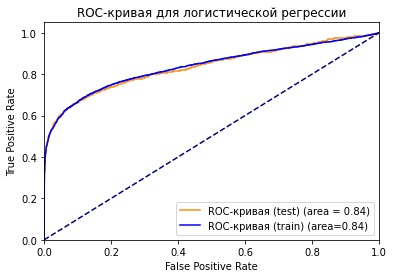

In [62]:
fpr_test, tpr_test, treshold_test = roc_curve(y_test, y_probs_test)
fpr_train, tpr_train, treshold_train = roc_curve(y_train, y_probs_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)
plt.plot(fpr_test, tpr_test, color='darkorange',
         label='ROC-кривая (test) (area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='blue', label='ROC-кривая (train) (area=%0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для логистической регрессии')
plt.legend(loc="lower right")
plt.show()

In [79]:
ece_score(y_test, y_probs)

0.13468006045289366

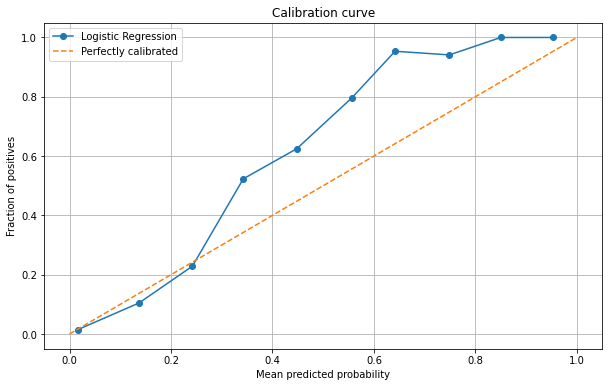

In [80]:
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [81]:
isotonic_clf = CalibratedClassifierCV(lr_model, cv=2, method="isotonic")
isotonic_clf.fit(X_test, y_test)
prob_pos_isotonic = isotonic_clf.predict_proba(X_test)[:, 1]

In [82]:
ece_score(y_test, prob_pos_isotonic)

0.04965887557809085

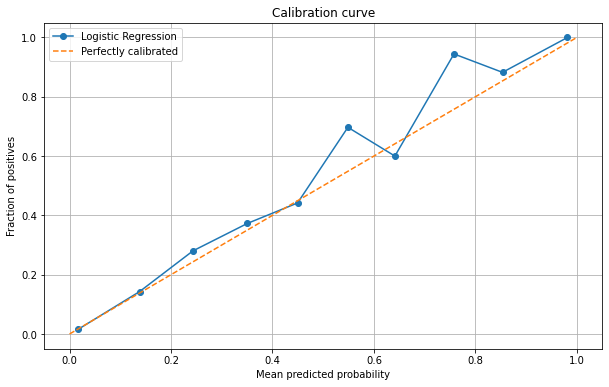

In [83]:
prob_true, prob_pred = calibration_curve(y_test, prob_pos_isotonic, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [63]:
rf_model = RandomForestClassifier(n_jobs=-1)
rf_model.fit(X_train, y_train)
print(classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     19308
           1       1.00      0.12      0.21       692

    accuracy                           0.97     20000
   macro avg       0.98      0.56      0.60     20000
weighted avg       0.97      0.97      0.96     20000



In [64]:
roc_auc_score(y_test, y_probs_test := rf_model.predict_proba(X_test)[:, 1])

0.9130137212883696

In [65]:
roc_auc_score(y_train, y_probs_train := rf_model.predict_proba(X_train)[:, 1])

1.0

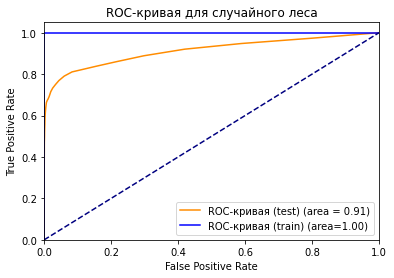

In [66]:
fpr_test, tpr_test, treshold_test = roc_curve(y_test, y_probs_test)
fpr_train, tpr_train, treshold_train = roc_curve(y_train, y_probs_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)
plt.plot(fpr_test, tpr_test, color='darkorange',
         label='ROC-кривая (test) (area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='blue', label='ROC-кривая (train) (area=%0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для случайного леса')
plt.legend(loc="lower right")
plt.show()

In [86]:
ece_score(y_test, y_probs)

0.2990588437921491

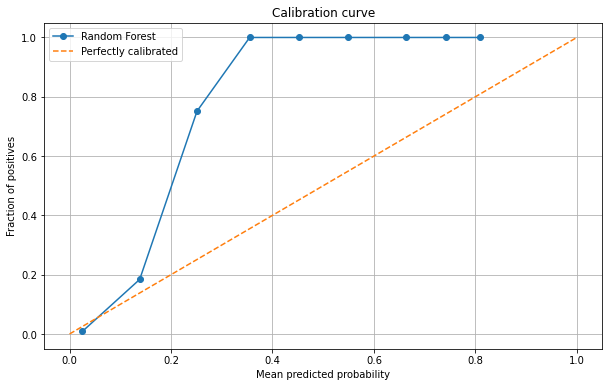

In [87]:
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [88]:
isotonic_clf = CalibratedClassifierCV(rf_model, cv=2, method="isotonic")
isotonic_clf.fit(X_test, y_test)
prob_pos_isotonic = isotonic_clf.predict_proba(X_test)[:, 1]

In [89]:
ece_score(y_test, prob_pos_isotonic)

0.23263520820672265

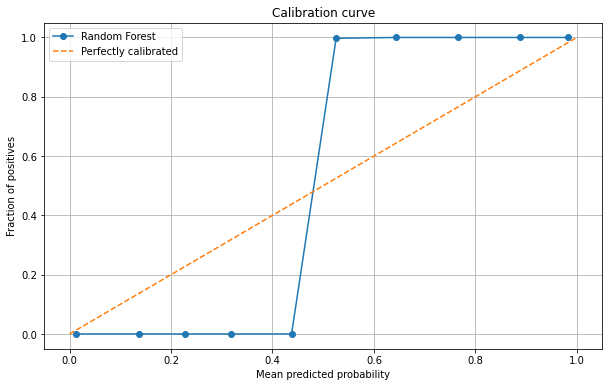

In [90]:
prob_true, prob_pred = calibration_curve(y_test, prob_pos_isotonic, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [67]:
catboost_model = CatBoostClassifier(task_type='GPU')
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)
catboost_model.fit(X_train, y_train, plot=True, use_best_model=False)
print(classification_report(y_test, catboost_model.predict(X_test)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.026491
0:	learn: 0.6493330	total: 6.64ms	remaining: 6.63s
1:	learn: 0.6078071	total: 12.9ms	remaining: 6.43s
2:	learn: 0.5723404	total: 19.1ms	remaining: 6.36s
3:	learn: 0.5392144	total: 25.5ms	remaining: 6.36s
4:	learn: 0.5066706	total: 31.6ms	remaining: 6.28s
5:	learn: 0.4795337	total: 37.7ms	remaining: 6.25s
6:	learn: 0.4523841	total: 43.6ms	remaining: 6.19s
7:	learn: 0.4274278	total: 49.6ms	remaining: 6.15s
8:	learn: 0.4050508	total: 56.1ms	remaining: 6.18s
9:	learn: 0.3835485	total: 62.3ms	remaining: 6.17s
10:	learn: 0.3634792	total: 68.6ms	remaining: 6.17s
11:	learn: 0.3444433	total: 74.7ms	remaining: 6.15s
12:	learn: 0.3279805	total: 80.6ms	remaining: 6.12s
13:	learn: 0.3123240	total: 86.8ms	remaining: 6.11s
14:	learn: 0.2985922	total: 92.6ms	remaining: 6.08s
15:	learn: 0.2848182	total: 98.7ms	remaining: 6.07s
16:	learn: 0.2728571	total: 105ms	remaining: 6.05s
17:	learn: 0.2612276	total: 110ms	remaining: 6.03s
18:	learn: 0.2514079	total: 117ms	remaining: 6

166:	learn: 0.0827261	total: 1.07s	remaining: 5.35s
167:	learn: 0.0824957	total: 1.08s	remaining: 5.35s
168:	learn: 0.0823907	total: 1.09s	remaining: 5.34s
169:	learn: 0.0821560	total: 1.09s	remaining: 5.33s
170:	learn: 0.0819997	total: 1.1s	remaining: 5.33s
171:	learn: 0.0818459	total: 1.1s	remaining: 5.32s
172:	learn: 0.0817095	total: 1.11s	remaining: 5.31s
173:	learn: 0.0815527	total: 1.12s	remaining: 5.31s
174:	learn: 0.0813956	total: 1.13s	remaining: 5.31s
175:	learn: 0.0812813	total: 1.13s	remaining: 5.3s
176:	learn: 0.0811424	total: 1.14s	remaining: 5.3s
177:	learn: 0.0809351	total: 1.15s	remaining: 5.29s
178:	learn: 0.0807546	total: 1.15s	remaining: 5.28s
179:	learn: 0.0806091	total: 1.16s	remaining: 5.27s
180:	learn: 0.0804185	total: 1.16s	remaining: 5.27s
181:	learn: 0.0802414	total: 1.17s	remaining: 5.26s
182:	learn: 0.0800555	total: 1.18s	remaining: 5.26s
183:	learn: 0.0798424	total: 1.18s	remaining: 5.25s
184:	learn: 0.0796908	total: 1.19s	remaining: 5.24s
185:	learn: 0.07

346:	learn: 0.0620869	total: 2.35s	remaining: 4.43s
347:	learn: 0.0620248	total: 2.36s	remaining: 4.43s
348:	learn: 0.0619644	total: 2.37s	remaining: 4.42s
349:	learn: 0.0619021	total: 2.38s	remaining: 4.41s
350:	learn: 0.0618414	total: 2.38s	remaining: 4.41s
351:	learn: 0.0617740	total: 2.39s	remaining: 4.4s
352:	learn: 0.0616868	total: 2.4s	remaining: 4.39s
353:	learn: 0.0616184	total: 2.4s	remaining: 4.38s
354:	learn: 0.0615565	total: 2.41s	remaining: 4.38s
355:	learn: 0.0615101	total: 2.42s	remaining: 4.37s
356:	learn: 0.0614762	total: 2.42s	remaining: 4.36s
357:	learn: 0.0614372	total: 2.43s	remaining: 4.36s
358:	learn: 0.0614010	total: 2.44s	remaining: 4.35s
359:	learn: 0.0613292	total: 2.44s	remaining: 4.34s
360:	learn: 0.0612869	total: 2.45s	remaining: 4.34s
361:	learn: 0.0612441	total: 2.46s	remaining: 4.33s
362:	learn: 0.0611759	total: 2.46s	remaining: 4.32s
363:	learn: 0.0611265	total: 2.47s	remaining: 4.31s
364:	learn: 0.0610496	total: 2.48s	remaining: 4.31s
365:	learn: 0.0

508:	learn: 0.0535065	total: 3.45s	remaining: 3.33s
509:	learn: 0.0534842	total: 3.46s	remaining: 3.32s
510:	learn: 0.0534304	total: 3.48s	remaining: 3.33s
511:	learn: 0.0534118	total: 3.49s	remaining: 3.33s
512:	learn: 0.0533668	total: 3.5s	remaining: 3.32s
513:	learn: 0.0533116	total: 3.51s	remaining: 3.32s
514:	learn: 0.0532643	total: 3.52s	remaining: 3.31s
515:	learn: 0.0532254	total: 3.52s	remaining: 3.3s
516:	learn: 0.0532150	total: 3.53s	remaining: 3.3s
517:	learn: 0.0531661	total: 3.54s	remaining: 3.29s
518:	learn: 0.0531380	total: 3.54s	remaining: 3.28s
519:	learn: 0.0531038	total: 3.55s	remaining: 3.28s
520:	learn: 0.0530806	total: 3.56s	remaining: 3.27s
521:	learn: 0.0530125	total: 3.56s	remaining: 3.26s
522:	learn: 0.0529779	total: 3.57s	remaining: 3.25s
523:	learn: 0.0529165	total: 3.58s	remaining: 3.25s
524:	learn: 0.0528965	total: 3.58s	remaining: 3.24s
525:	learn: 0.0528470	total: 3.59s	remaining: 3.23s
526:	learn: 0.0527915	total: 3.6s	remaining: 3.23s
527:	learn: 0.05

689:	learn: 0.0483358	total: 4.7s	remaining: 2.11s
690:	learn: 0.0483178	total: 4.71s	remaining: 2.11s
691:	learn: 0.0482917	total: 4.72s	remaining: 2.1s
692:	learn: 0.0482830	total: 4.72s	remaining: 2.09s
693:	learn: 0.0482492	total: 4.73s	remaining: 2.09s
694:	learn: 0.0482336	total: 4.74s	remaining: 2.08s
695:	learn: 0.0482077	total: 4.75s	remaining: 2.07s
696:	learn: 0.0481957	total: 4.75s	remaining: 2.06s
697:	learn: 0.0481726	total: 4.76s	remaining: 2.06s
698:	learn: 0.0481402	total: 4.76s	remaining: 2.05s
699:	learn: 0.0481246	total: 4.77s	remaining: 2.04s
700:	learn: 0.0481081	total: 4.78s	remaining: 2.04s
701:	learn: 0.0480766	total: 4.78s	remaining: 2.03s
702:	learn: 0.0480647	total: 4.79s	remaining: 2.02s
703:	learn: 0.0480432	total: 4.8s	remaining: 2.02s
704:	learn: 0.0480220	total: 4.8s	remaining: 2.01s
705:	learn: 0.0480111	total: 4.81s	remaining: 2s
706:	learn: 0.0480021	total: 4.82s	remaining: 2s
707:	learn: 0.0479742	total: 4.83s	remaining: 1.99s
708:	learn: 0.0479618	

871:	learn: 0.0449037	total: 5.95s	remaining: 874ms
872:	learn: 0.0448893	total: 5.96s	remaining: 867ms
873:	learn: 0.0448696	total: 5.97s	remaining: 860ms
874:	learn: 0.0448583	total: 5.97s	remaining: 854ms
875:	learn: 0.0448481	total: 5.98s	remaining: 847ms
876:	learn: 0.0448408	total: 5.99s	remaining: 840ms
877:	learn: 0.0448231	total: 5.99s	remaining: 833ms
878:	learn: 0.0448064	total: 6s	remaining: 826ms
879:	learn: 0.0447971	total: 6.01s	remaining: 819ms
880:	learn: 0.0447826	total: 6.01s	remaining: 812ms
881:	learn: 0.0447557	total: 6.02s	remaining: 805ms
882:	learn: 0.0447467	total: 6.03s	remaining: 799ms
883:	learn: 0.0447349	total: 6.03s	remaining: 792ms
884:	learn: 0.0447251	total: 6.04s	remaining: 785ms
885:	learn: 0.0447074	total: 6.04s	remaining: 778ms
886:	learn: 0.0446971	total: 6.05s	remaining: 771ms
887:	learn: 0.0446887	total: 6.06s	remaining: 764ms
888:	learn: 0.0446779	total: 6.06s	remaining: 757ms
889:	learn: 0.0446702	total: 6.07s	remaining: 750ms
890:	learn: 0.0

In [68]:
roc_auc_score(y_test, y_probs_test := catboost_model.predict_proba(X_test)[:, 1])

0.932684915414378

In [69]:
roc_auc_score(y_train, y_probs_train := catboost_model.predict_proba(X_train)[:, 1])

0.9707560420012191

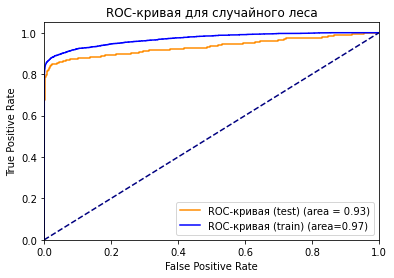

In [70]:
fpr_test, tpr_test, treshold_test = roc_curve(y_test, y_probs_test)
fpr_train, tpr_train, treshold_train = roc_curve(y_train, y_probs_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)
plt.plot(fpr_test, tpr_test, color='darkorange',
         label='ROC-кривая (test) (area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='blue', label='ROC-кривая (train) (area=%0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для случайного леса')
plt.legend(loc="lower right")
plt.show()

In [93]:
ece_score(y_test, y_probs)

0.2442704383024851

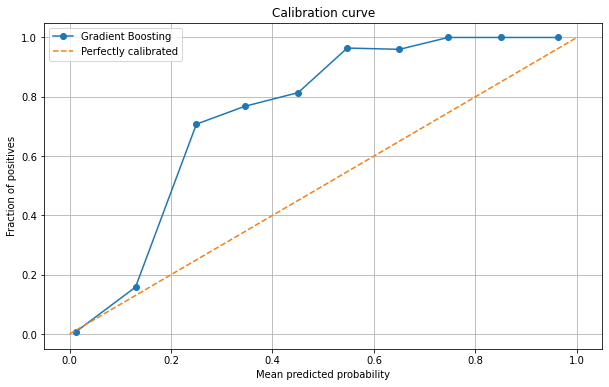

In [94]:
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Gradient Boosting')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

In [95]:
isotonic_clf = CalibratedClassifierCV(catboost_model, cv=2, method="isotonic")
isotonic_clf.fit(X_test, y_test)
prob_pos_isotonic = isotonic_clf.predict_proba(X_test)[:, 1]

Learning rate set to 0.029701
0:	learn: 0.6468226	total: 17ms	remaining: 17s
1:	learn: 0.6049079	total: 48.7ms	remaining: 24.3s
2:	learn: 0.5667522	total: 66.3ms	remaining: 22s
3:	learn: 0.5321924	total: 85.4ms	remaining: 21.3s
4:	learn: 0.4962534	total: 120ms	remaining: 23.8s
5:	learn: 0.4672906	total: 138ms	remaining: 22.8s
6:	learn: 0.4411882	total: 154ms	remaining: 21.8s
7:	learn: 0.4152655	total: 187ms	remaining: 23.2s
8:	learn: 0.3900900	total: 220ms	remaining: 24.3s
9:	learn: 0.3685856	total: 242ms	remaining: 23.9s
10:	learn: 0.3479392	total: 274ms	remaining: 24.6s
11:	learn: 0.3286802	total: 305ms	remaining: 25.1s
12:	learn: 0.3140866	total: 318ms	remaining: 24.1s
13:	learn: 0.2983837	total: 347ms	remaining: 24.4s
14:	learn: 0.2846586	total: 373ms	remaining: 24.5s
15:	learn: 0.2714713	total: 400ms	remaining: 24.6s
16:	learn: 0.2590000	total: 427ms	remaining: 24.7s
17:	learn: 0.2480535	total: 455ms	remaining: 24.8s
18:	learn: 0.2390297	total: 481ms	remaining: 24.8s
19:	learn: 0.

166:	learn: 0.0680767	total: 4.64s	remaining: 23.1s
167:	learn: 0.0679369	total: 4.67s	remaining: 23.1s
168:	learn: 0.0676772	total: 4.7s	remaining: 23.1s
169:	learn: 0.0674465	total: 4.73s	remaining: 23.1s
170:	learn: 0.0672614	total: 4.76s	remaining: 23.1s
171:	learn: 0.0669984	total: 4.79s	remaining: 23.1s
172:	learn: 0.0668717	total: 4.82s	remaining: 23s
173:	learn: 0.0667251	total: 4.84s	remaining: 23s
174:	learn: 0.0664910	total: 4.88s	remaining: 23s
175:	learn: 0.0663489	total: 4.9s	remaining: 23s
176:	learn: 0.0660769	total: 4.93s	remaining: 22.9s
177:	learn: 0.0657717	total: 4.96s	remaining: 22.9s
178:	learn: 0.0655059	total: 4.99s	remaining: 22.9s
179:	learn: 0.0653230	total: 5.01s	remaining: 22.8s
180:	learn: 0.0651356	total: 5.04s	remaining: 22.8s
181:	learn: 0.0650130	total: 5.07s	remaining: 22.8s
182:	learn: 0.0648493	total: 5.09s	remaining: 22.7s
183:	learn: 0.0646484	total: 5.12s	remaining: 22.7s
184:	learn: 0.0643458	total: 5.15s	remaining: 22.7s
185:	learn: 0.0642121	

329:	learn: 0.0442120	total: 9.26s	remaining: 18.8s
330:	learn: 0.0441061	total: 9.29s	remaining: 18.8s
331:	learn: 0.0440084	total: 9.32s	remaining: 18.7s
332:	learn: 0.0439273	total: 9.34s	remaining: 18.7s
333:	learn: 0.0437984	total: 9.37s	remaining: 18.7s
334:	learn: 0.0436661	total: 9.4s	remaining: 18.7s
335:	learn: 0.0435959	total: 9.43s	remaining: 18.6s
336:	learn: 0.0433936	total: 9.46s	remaining: 18.6s
337:	learn: 0.0432980	total: 9.49s	remaining: 18.6s
338:	learn: 0.0431683	total: 9.52s	remaining: 18.6s
339:	learn: 0.0430739	total: 9.55s	remaining: 18.5s
340:	learn: 0.0428908	total: 9.58s	remaining: 18.5s
341:	learn: 0.0428090	total: 9.6s	remaining: 18.5s
342:	learn: 0.0427541	total: 9.63s	remaining: 18.4s
343:	learn: 0.0426903	total: 9.66s	remaining: 18.4s
344:	learn: 0.0425236	total: 9.69s	remaining: 18.4s
345:	learn: 0.0423787	total: 9.71s	remaining: 18.4s
346:	learn: 0.0423356	total: 9.74s	remaining: 18.3s
347:	learn: 0.0422861	total: 9.77s	remaining: 18.3s
348:	learn: 0.

495:	learn: 0.0301672	total: 13.9s	remaining: 14.1s
496:	learn: 0.0300293	total: 13.9s	remaining: 14.1s
497:	learn: 0.0299776	total: 13.9s	remaining: 14.1s
498:	learn: 0.0298763	total: 14s	remaining: 14s
499:	learn: 0.0298198	total: 14s	remaining: 14s
500:	learn: 0.0297662	total: 14s	remaining: 14s
501:	learn: 0.0297190	total: 14.1s	remaining: 13.9s
502:	learn: 0.0296685	total: 14.1s	remaining: 13.9s
503:	learn: 0.0296183	total: 14.1s	remaining: 13.9s
504:	learn: 0.0295414	total: 14.1s	remaining: 13.9s
505:	learn: 0.0294582	total: 14.2s	remaining: 13.8s
506:	learn: 0.0293902	total: 14.2s	remaining: 13.8s
507:	learn: 0.0292760	total: 14.2s	remaining: 13.8s
508:	learn: 0.0292314	total: 14.3s	remaining: 13.8s
509:	learn: 0.0291723	total: 14.3s	remaining: 13.7s
510:	learn: 0.0291257	total: 14.3s	remaining: 13.7s
511:	learn: 0.0290826	total: 14.4s	remaining: 13.7s
512:	learn: 0.0290012	total: 14.4s	remaining: 13.7s
513:	learn: 0.0289602	total: 14.4s	remaining: 13.6s
514:	learn: 0.0288703	to

659:	learn: 0.0214421	total: 18.5s	remaining: 9.54s
660:	learn: 0.0213925	total: 18.6s	remaining: 9.52s
661:	learn: 0.0213791	total: 18.6s	remaining: 9.49s
662:	learn: 0.0213246	total: 18.6s	remaining: 9.46s
663:	learn: 0.0212876	total: 18.6s	remaining: 9.43s
664:	learn: 0.0212225	total: 18.7s	remaining: 9.4s
665:	learn: 0.0211885	total: 18.7s	remaining: 9.37s
666:	learn: 0.0211190	total: 18.7s	remaining: 9.35s
667:	learn: 0.0210603	total: 18.7s	remaining: 9.32s
668:	learn: 0.0210250	total: 18.8s	remaining: 9.29s
669:	learn: 0.0209573	total: 18.8s	remaining: 9.26s
670:	learn: 0.0208968	total: 18.8s	remaining: 9.23s
671:	learn: 0.0208610	total: 18.9s	remaining: 9.2s
672:	learn: 0.0208024	total: 18.9s	remaining: 9.18s
673:	learn: 0.0207737	total: 18.9s	remaining: 9.15s
674:	learn: 0.0207443	total: 18.9s	remaining: 9.12s
675:	learn: 0.0206926	total: 19s	remaining: 9.09s
676:	learn: 0.0206556	total: 19s	remaining: 9.06s
677:	learn: 0.0206238	total: 19s	remaining: 9.03s
678:	learn: 0.020575

819:	learn: 0.0156295	total: 22.9s	remaining: 5.03s
820:	learn: 0.0156088	total: 22.9s	remaining: 5s
821:	learn: 0.0155795	total: 23s	remaining: 4.97s
822:	learn: 0.0155428	total: 23s	remaining: 4.95s
823:	learn: 0.0155290	total: 23s	remaining: 4.92s
824:	learn: 0.0155088	total: 23.1s	remaining: 4.89s
825:	learn: 0.0154988	total: 23.1s	remaining: 4.86s
826:	learn: 0.0154791	total: 23.1s	remaining: 4.83s
827:	learn: 0.0154359	total: 23.1s	remaining: 4.8s
828:	learn: 0.0153990	total: 23.2s	remaining: 4.78s
829:	learn: 0.0153741	total: 23.2s	remaining: 4.75s
830:	learn: 0.0153508	total: 23.2s	remaining: 4.72s
831:	learn: 0.0153249	total: 23.2s	remaining: 4.69s
832:	learn: 0.0152874	total: 23.3s	remaining: 4.66s
833:	learn: 0.0152555	total: 23.3s	remaining: 4.64s
834:	learn: 0.0152353	total: 23.3s	remaining: 4.61s
835:	learn: 0.0152144	total: 23.4s	remaining: 4.58s
836:	learn: 0.0151703	total: 23.4s	remaining: 4.55s
837:	learn: 0.0151346	total: 23.4s	remaining: 4.52s
838:	learn: 0.0151052	

984:	learn: 0.0116283	total: 27.5s	remaining: 420ms
985:	learn: 0.0116126	total: 27.6s	remaining: 392ms
986:	learn: 0.0115990	total: 27.6s	remaining: 364ms
987:	learn: 0.0115890	total: 27.6s	remaining: 336ms
988:	learn: 0.0115454	total: 27.7s	remaining: 308ms
989:	learn: 0.0115317	total: 27.7s	remaining: 280ms
990:	learn: 0.0115187	total: 27.7s	remaining: 252ms
991:	learn: 0.0114906	total: 27.8s	remaining: 224ms
992:	learn: 0.0114739	total: 27.8s	remaining: 196ms
993:	learn: 0.0114520	total: 27.8s	remaining: 168ms
994:	learn: 0.0114422	total: 27.8s	remaining: 140ms
995:	learn: 0.0114232	total: 27.9s	remaining: 112ms
996:	learn: 0.0114025	total: 27.9s	remaining: 83.9ms
997:	learn: 0.0113806	total: 27.9s	remaining: 55.9ms
998:	learn: 0.0113732	total: 27.9s	remaining: 28ms
999:	learn: 0.0113640	total: 28s	remaining: 0us
Learning rate set to 0.029701
0:	learn: 0.6468173	total: 17.3ms	remaining: 17.3s
1:	learn: 0.6020299	total: 46.8ms	remaining: 23.4s
2:	learn: 0.5637417	total: 75.4ms	remai

150:	learn: 0.0689705	total: 4.17s	remaining: 23.4s
151:	learn: 0.0687583	total: 4.2s	remaining: 23.4s
152:	learn: 0.0683213	total: 4.22s	remaining: 23.4s
153:	learn: 0.0681235	total: 4.25s	remaining: 23.3s
154:	learn: 0.0679736	total: 4.28s	remaining: 23.3s
155:	learn: 0.0674419	total: 4.3s	remaining: 23.3s
156:	learn: 0.0673360	total: 4.33s	remaining: 23.3s
157:	learn: 0.0671747	total: 4.36s	remaining: 23.3s
158:	learn: 0.0668750	total: 4.39s	remaining: 23.2s
159:	learn: 0.0667487	total: 4.42s	remaining: 23.2s
160:	learn: 0.0664387	total: 4.45s	remaining: 23.2s
161:	learn: 0.0662545	total: 4.47s	remaining: 23.1s
162:	learn: 0.0660546	total: 4.5s	remaining: 23.1s
163:	learn: 0.0658122	total: 4.53s	remaining: 23.1s
164:	learn: 0.0655564	total: 4.56s	remaining: 23.1s
165:	learn: 0.0652375	total: 4.59s	remaining: 23s
166:	learn: 0.0650765	total: 4.62s	remaining: 23s
167:	learn: 0.0648437	total: 4.64s	remaining: 23s
168:	learn: 0.0647290	total: 4.67s	remaining: 23s
169:	learn: 0.0644811	t

314:	learn: 0.0427725	total: 8.73s	remaining: 19s
315:	learn: 0.0426320	total: 8.76s	remaining: 19s
316:	learn: 0.0424681	total: 8.79s	remaining: 18.9s
317:	learn: 0.0423785	total: 8.82s	remaining: 18.9s
318:	learn: 0.0423089	total: 8.85s	remaining: 18.9s
319:	learn: 0.0422299	total: 8.88s	remaining: 18.9s
320:	learn: 0.0421800	total: 8.9s	remaining: 18.8s
321:	learn: 0.0421342	total: 8.94s	remaining: 18.8s
322:	learn: 0.0420504	total: 8.96s	remaining: 18.8s
323:	learn: 0.0419625	total: 8.99s	remaining: 18.8s
324:	learn: 0.0419064	total: 9.02s	remaining: 18.7s
325:	learn: 0.0417833	total: 9.04s	remaining: 18.7s
326:	learn: 0.0416725	total: 9.07s	remaining: 18.7s
327:	learn: 0.0415291	total: 9.1s	remaining: 18.6s
328:	learn: 0.0414464	total: 9.13s	remaining: 18.6s
329:	learn: 0.0413914	total: 9.15s	remaining: 18.6s
330:	learn: 0.0412643	total: 9.18s	remaining: 18.6s
331:	learn: 0.0411912	total: 9.21s	remaining: 18.5s
332:	learn: 0.0411070	total: 9.23s	remaining: 18.5s
333:	learn: 0.0409

473:	learn: 0.0302030	total: 13.1s	remaining: 14.6s
474:	learn: 0.0301380	total: 13.1s	remaining: 14.5s
475:	learn: 0.0300572	total: 13.2s	remaining: 14.5s
476:	learn: 0.0299922	total: 13.2s	remaining: 14.5s
477:	learn: 0.0299268	total: 13.2s	remaining: 14.4s
478:	learn: 0.0298566	total: 13.3s	remaining: 14.4s
479:	learn: 0.0297581	total: 13.3s	remaining: 14.4s
480:	learn: 0.0297169	total: 13.3s	remaining: 14.4s
481:	learn: 0.0296667	total: 13.3s	remaining: 14.3s
482:	learn: 0.0296431	total: 13.4s	remaining: 14.3s
483:	learn: 0.0295812	total: 13.4s	remaining: 14.3s
484:	learn: 0.0295436	total: 13.4s	remaining: 14.3s
485:	learn: 0.0294542	total: 13.5s	remaining: 14.2s
486:	learn: 0.0294169	total: 13.5s	remaining: 14.2s
487:	learn: 0.0293473	total: 13.5s	remaining: 14.2s
488:	learn: 0.0293223	total: 13.5s	remaining: 14.1s
489:	learn: 0.0292649	total: 13.6s	remaining: 14.1s
490:	learn: 0.0291675	total: 13.6s	remaining: 14.1s
491:	learn: 0.0291134	total: 13.6s	remaining: 14.1s
492:	learn: 

637:	learn: 0.0220346	total: 17.7s	remaining: 10s
638:	learn: 0.0220063	total: 17.7s	remaining: 10s
639:	learn: 0.0219473	total: 17.7s	remaining: 9.98s
640:	learn: 0.0219090	total: 17.8s	remaining: 9.95s
641:	learn: 0.0218906	total: 17.8s	remaining: 9.92s
642:	learn: 0.0218214	total: 17.8s	remaining: 9.9s
643:	learn: 0.0217875	total: 17.9s	remaining: 9.87s
644:	learn: 0.0217401	total: 17.9s	remaining: 9.84s
645:	learn: 0.0216839	total: 17.9s	remaining: 9.82s
646:	learn: 0.0216239	total: 17.9s	remaining: 9.79s
647:	learn: 0.0215454	total: 18s	remaining: 9.76s
648:	learn: 0.0215213	total: 18s	remaining: 9.74s
649:	learn: 0.0214779	total: 18s	remaining: 9.71s
650:	learn: 0.0214223	total: 18.1s	remaining: 9.68s
651:	learn: 0.0214030	total: 18.1s	remaining: 9.65s
652:	learn: 0.0213692	total: 18.1s	remaining: 9.62s
653:	learn: 0.0213520	total: 18.1s	remaining: 9.6s
654:	learn: 0.0213343	total: 18.2s	remaining: 9.57s
655:	learn: 0.0212991	total: 18.2s	remaining: 9.54s
656:	learn: 0.0212743	to

803:	learn: 0.0161690	total: 22.4s	remaining: 5.45s
804:	learn: 0.0161353	total: 22.4s	remaining: 5.43s
805:	learn: 0.0160881	total: 22.4s	remaining: 5.4s
806:	learn: 0.0160662	total: 22.5s	remaining: 5.37s
807:	learn: 0.0160441	total: 22.5s	remaining: 5.34s
808:	learn: 0.0160401	total: 22.5s	remaining: 5.32s
809:	learn: 0.0160094	total: 22.6s	remaining: 5.29s
810:	learn: 0.0159873	total: 22.6s	remaining: 5.26s
811:	learn: 0.0159533	total: 22.6s	remaining: 5.24s
812:	learn: 0.0158928	total: 22.6s	remaining: 5.21s
813:	learn: 0.0158646	total: 22.7s	remaining: 5.18s
814:	learn: 0.0158193	total: 22.7s	remaining: 5.15s
815:	learn: 0.0157857	total: 22.7s	remaining: 5.13s
816:	learn: 0.0157736	total: 22.8s	remaining: 5.1s
817:	learn: 0.0157559	total: 22.8s	remaining: 5.07s
818:	learn: 0.0157167	total: 22.8s	remaining: 5.04s
819:	learn: 0.0156981	total: 22.8s	remaining: 5.01s
820:	learn: 0.0156799	total: 22.9s	remaining: 4.99s
821:	learn: 0.0156680	total: 22.9s	remaining: 4.96s
822:	learn: 0.

966:	learn: 0.0118054	total: 27s	remaining: 923ms
967:	learn: 0.0117687	total: 27.1s	remaining: 895ms
968:	learn: 0.0117206	total: 27.1s	remaining: 867ms
969:	learn: 0.0117025	total: 27.1s	remaining: 839ms
970:	learn: 0.0116785	total: 27.2s	remaining: 811ms
971:	learn: 0.0116619	total: 27.2s	remaining: 783ms
972:	learn: 0.0116360	total: 27.2s	remaining: 755ms
973:	learn: 0.0115988	total: 27.2s	remaining: 727ms
974:	learn: 0.0115833	total: 27.3s	remaining: 699ms
975:	learn: 0.0115663	total: 27.3s	remaining: 671ms
976:	learn: 0.0115597	total: 27.3s	remaining: 643ms
977:	learn: 0.0115541	total: 27.4s	remaining: 615ms
978:	learn: 0.0114916	total: 27.4s	remaining: 587ms
979:	learn: 0.0114560	total: 27.4s	remaining: 559ms
980:	learn: 0.0114390	total: 27.4s	remaining: 531ms
981:	learn: 0.0114267	total: 27.5s	remaining: 503ms
982:	learn: 0.0114035	total: 27.5s	remaining: 475ms
983:	learn: 0.0113863	total: 27.5s	remaining: 447ms
984:	learn: 0.0113522	total: 27.5s	remaining: 420ms
985:	learn: 0.

In [96]:
ece_score(y_test, prob_pos_isotonic)

0.20112498897673256

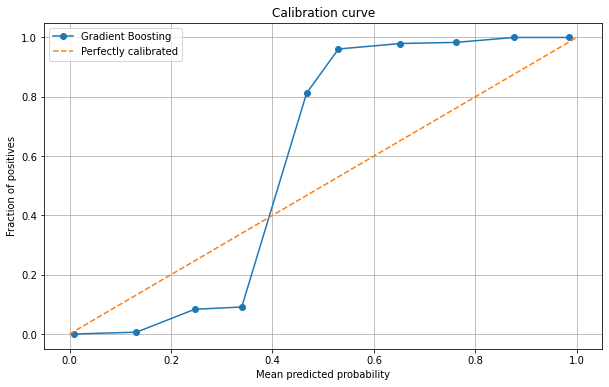

In [97]:
prob_true, prob_pred = calibration_curve(y_test, prob_pos_isotonic, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Gradient Boosting')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.grid()
plt.show()

Лучше всего откалибрована модель логистической регрессии => используем её результаты

In [177]:
result = {'client_id': range(n_items := test_df.shape[0]),
          'product': ['credit'] * n_items,
          'channel': ['sms'] * n_items,
          'score': list(prob_pos_isotonic)}

result_df = pd.DataFrame(result)
result_df.to_csv('credit_sms_result.csv')

# Построение датасета для задачи оптимизации

In [178]:
df1 = pd.read_csv('credit_card_call_result.csv')
df2 = pd.read_csv('credit_card_sms_result.csv')
df3 = pd.read_csv('credit_call_result.csv')
df4 = pd.read_csv('credit_sms_result.csv')

In [179]:
df1 = df1.drop(['Unnamed: 0'], axis=1)
df2 = df2.drop(['Unnamed: 0'], axis=1)
df3 = df3.drop(['Unnamed: 0'], axis=1)
df4 = df4.drop(['Unnamed: 0'], axis=1)

In [184]:
optimization_df = pd.DataFrame(columns=['client_id', 'product', 'channel', 'score'])

for i in range(df1.shape[0]):
    optimization_df.loc[len(optimization_df)] = df1.loc[i]
    optimization_df.loc[len(optimization_df)] = df2.loc[i]
    optimization_df.loc[len(optimization_df)] = df3.loc[i]
    optimization_df.loc[len(optimization_df)] = df4.loc[i]

In [185]:
optimization_df.head(10)

,client_id,product,channel,score
0,0,credit card,call,0.021752
1,0,credit card,sms,0.005114
2,0,credit,call,0.923996
3,0,credit,sms,0.009079
4,1,credit card,call,0.017157
5,1,credit card,sms,0.006544
6,1,credit,call,0.08395
7,1,credit,sms,0.045296
8,2,credit card,call,0.018123
9,2,credit card,sms,0.005872


In [186]:
optimization_df.to_csv('optimization_data.csv')